# Quantum Network Link Simulator (Algebra-Based)
### Adjacent to: Qunnect / Cisco GothamQ Demonstration, NYC, Feb 18 2026

---

This **simulator** takes hardware parameters (T_mem, F_source, p_s, eta_det) as inputs
and computes network-level outcomes (rate, fidelity, max repeater spacing,
infrastructure count, CapEx).

---

## Context: what was just demonstrated

On **February 18, 2026**, Qunnect and Cisco announced the first metro-scale,
high-speed quantum entanglement swapping over commercial deployed fiber:

| Metric | Achieved | Source |
|---|---|---|
| Total fiber span | 17.6 km | Brooklyn Navy Yard to 60 Hudson St, Manhattan |
| Local swapping rate | 1.7 M+ pairs/hour | GothamQ testbed |
| Metro fiber rate | 5,400 pairs/hour | Deployed NYC fiber |
| Polarization fidelity | >99% | Qunnect Qu-APC stabilization |
| Architecture | Hub-and-spoke | 60 Hudson St as BSM node H |
| Classical layer | Cisco Software Orchestrator | Quantum Network Orchestrator |
| Quantum layer | Qunnect Carina suite | Room-temperature endpoints |

*Sources: Qunnect/Cisco press release Feb 18 2026 (arXiv paper linked therein);*
*PRX Quantum 5, 030330 (2024) -- GothamQ 34 km loop*

---

**Disclaimer (independent work):** This simulator and all variable names, labels, and
groupings (including any references to “Qunnect” or “Cisco”) are chosen by the author
for clarity and do not represent official vendor terminology, specifications,
commitments, or endorsements. The model is an independent, educational/planning
tool; any cost figures are illustrative placeholders unless explicitly cited from public
sources.

---

## Two-vendor architecture: parameter ownership

```
Quantum frontend (sets physical limits)
  Qu-LSR        Warm Rb vapor quantum memory  ->  T_mem [coherence time]
  Qu-APC        Automated polarization control ->  F_source [entanglement fidelity]
  QU-SOURCE     SPDC entanglement source       ->  f_rep, brightness
  SNSPDs        Single-photon detectors        ->  eta_det, p_dc

Classical backend (sets operational constraints)
  Fiber plant   Deployed telecom fiber         ->  alpha [dB/km], L_total
  White Rabbit  Sub-ns timing synchronization  ->  contributes to p_dc via jitter
  Orchestrator  SDN herald dispatch            ->  tau_orch [latency overhead]
  DWDM          Classical/quantum coexistence  ->  crosstalk -> p_dc

INTERFACE      (the Solution Architect conversation)
  tau_orch      Classical control-plane latency adds directly to heralding wait
  p_dc          DWDM crosstalk raises effective dark-count rate above SNSPD floor
  Technology constraint identifies which vendor owns the bottleneck at any (L, T_mem)
```

---

## Physical model

### Topology: S1 --[L1 km]-- H --[L2 km]-- S2
```
  L1 = f_H * L_total        f_H in (0,1)
  L2 = (1 - f_H) * L_total
  f_H = 0.5  ->  symmetric midpoint
  f_H != 0.5 ->  asymmetric (e.g. 60 Hudson not at geometric midpoint)
```

### Per-arm transmittance (Beer-Lambert)
```
  eta_i = eta_det * 10^(-alpha_i * Li / 10)
```

### Entanglement success probability per clock cycle
```
  P_success = p_s * eta_1 * eta_2
  KEY INSIGHT (symmetric alpha_1 = alpha_2):
    P_success = p_s * eta_det^2 * 10^(-alpha * L_total / 10)
    Independent of f_H. H position is a free optimization parameter for rate.
```

### Heralding latency
```
  tau_herald = L_total / c_fiber + tau_orch    [independent of f_H]
  c_fiber = 2e8 m/s  (n ~ 1.5)
```

### Entanglement generation rate [pairs/s]
```
  R = P_success * f_rep / (1 + f_rep * tau_herald)
  Renewal process model: Sangouard et al., Rev. Mod. Phys. 83, 33 (2011)
```

### Distributed entanglement fidelity
```
  F = F_source * exp(-tau_herald / T_mem) * (1 - 2 * p_dc)
```

### Inversion: P_success target -> max repeater spacing d [km]
```
  d_rate    = -(10/alpha) * log10(P_target / (p_s * eta_det^2))  [loss-limited]
  d_fidelity = c_fiber * (T_mem * ln(A / F_min) - tau_orch)       [memory-limited]
  d = min(d_rate, d_fidelity)
  binding = argmin -> tells customer: Cisco play or Qunnect play
```

### Infrastructure estimate
```
  N_repeaters = ceil(Area / d^2)    [square grid]
  N_links     = ceil(2 * Area / d^2)
  CapEx = N_rep * C_node + N_links * d * C_fiber  [ORDER-OF-MAGNITUDE -- not vendor quotes]
```

---

## Assumptions and caveats

| Assumption | Direction of error | Remedy in Sim 2 |
|---|---|---|
| Symmetric loss within each arm | Underestimates on irregular routes | Per-segment loss budget |
| Single photon pair per clock cycle | Misses multi-photon errors | Source brightness model |
| Exponential memory decoherence | Conservative for some technologies | Lindblad master equation |
| Square grid topology | Overestimates coverage on irregular areas | Graph-theoretic model |
| BSM p_s capped at 0.5 | Linear optics fundamental limit | PNR detectors or auxiliary entanglement |

---


In [1]:
# ===========================================================================
# CELL 1 -- Physics engine & parameter register
# All computation lives here. No plots. No widgets.
#
# Named outputs produced by this cell:
#   PARAMS          full parameter register
#   GOTHAMQ         verified GothamQ/Qunnect published parameters
#   CARRIER         carrier-deployable target parameters
#   MEM_TIERS       memory technology roadmap tiers
#   df_sweep_fH     rate & P_success vs. H position (asymmetry sweep)
#   df_sweep_L      rate & fidelity vs. total distance (3 memory tiers)
#   df_phase        phase diagram arrays: T_mem x L grid
#   df_d_vs_Ps      max spacing d vs. P_success target (3 memory tiers)
#   df_scenarios    scenario comparison table
# ===========================================================================

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.float_format", "{:.4g}".format)

# -- Physical constants ------------------------------------------------------
C_FIBER_M_S  = 2.0e8          # speed of light in fiber [m/s]  (n ~ 1.5)
C_FIBER_KM_S = C_FIBER_M_S / 1e3

# -- Parameter register ------------------------------------------------------
# VERIFIED SOURCES:
# [G26] Qunnect/Cisco press release Feb 18 2026 + arXiv
#       17.6 km GothamQ; 5,400 pairs/hr over fiber; >99% polarization fidelity
# [G24] Craddock et al., PRX Quantum 5, 030330 (2024)
#       34 km GothamQ loop; 1324 nm telecom photon on NYC deployed fiber
# [Q23] Qunnect/NYU press release Sept 2023
#       16 km link; 15,000 pairs/sec; 99% uptime
# [Q21] Qunnect press release Nov 2021
#       First commercial quantum memory; fidelity > 95%
# [Q_arxiv] Wang et al. arXiv 2025
#       Utility time up to 3 us; limited by atomic diffusion
# [S11] Sangouard et al., Rev. Mod. Phys. 83, 33 (2011)
#       Renewal process rate model; BSM p_s <= 0.5 for linear optics
# [N23] NIST Single-Photon Detectors page 2023
#       SNSPD: >98% efficiency, <1e-3 dark counts/s, <3 ps jitter
# [ITU] ITU-T G.652 -- SMF-28: 0.2 dB/km at 1550 nm; ~0.35 at 1324 nm

PARAMS = {
    # Qunnect parameters
    "T_mem_us": {
        "value": 3.0, "units": "microseconds", "vendor": "Qunnect",
        "source": ("Qu-LSR warm Rb vapor. Wang et al. arXiv 2025: utility time "
                   "up to 3 us; limited by atomic diffusion. Anti-relaxation "
                   "coating target: ~100 us near-term, ~1 ms long-term."),
        "ref": "[Q_arxiv] Wang et al. arXiv 2025; [Q21] Qunnect 2021",
        "roadmap": {"current_us": 3.0, "near_term_us": 100.0, "target_us": 1000.0},
    },
    "F_source": {
        "value": 0.99, "units": "dimensionless", "vendor": "Qunnect",
        "source": ("Qu-APC automated polarization compensation. GothamQ Feb 2026: "
                   ">99% polarization fidelity over 17.6 km deployed fiber."),
        "ref": "[G26] Qunnect/Cisco Feb 2026; [Q21] >95% fidelity",
    },
    "f_rep_MHz": {
        "value": 10.0, "units": "MHz", "vendor": "Qunnect",
        "source": ("QU-SOURCE SPDC. GothamQ loop operated at 10 MHz. "
                   "QU-SOURCE: >10M pairs/s = 10 MHz pair rate."),
        "ref": "[G24] PRX Quantum 5, 030330 (2024); [Q23] Qunnect 2023",
    },
    "p_s": {
        "value": 0.50, "units": "dimensionless", "vendor": "Qunnect + Cisco",
        "source": ("BSM success probability. Linear optics fundamental limit: "
                   "p_s <= 0.5 (Lutkenhaus et al. 1999). Hard architectural ceiling."),
        "ref": "[S11] Sangouard et al. RMP 2011; Lutkenhaus et al. PRA 1999",
    },
    "eta_det": {
        "value": 0.90, "units": "dimensionless", "vendor": "Qunnect",
        "source": ("SNSPD system efficiency at 1324 nm. State-of-art: >98% at "
                   "1550 nm (NIST 2023). Conservative 0.90 for system efficiency "
                   "including fiber coupling at 1324 nm."),
        "ref": "[N23] NIST SPD page 2023",
    },
    "p_dc": {
        "value": 1e-5, "units": "per detection window", "vendor": "Cisco + Qunnect",
        "source": ("SNSPD intrinsic DCR <1e-3/s (NIST 2023). DWDM crosstalk "
                   "dominates in deployed fiber. Effective p_dc ~1e-5 to 1e-4 "
                   "in comparable metro deployments."),
        "ref": "[N23] NIST 2023; [G24] PRX Quantum 2024",
    },
    # Cisco parameters
    "alpha_dBkm": {
        "value": 0.35, "units": "dB/km", "vendor": "Cisco",
        "source": ("SMF-28 at 1324 nm. ITU-T G.652: 0.2 dB/km at 1550 nm; "
                   "~0.32-0.38 at 1324 nm. GothamQ uses NYC deployed fiber."),
        "ref": "[ITU] ITU-T G.652; [G24] PRX Quantum 2024",
    },
    "tau_orch_us": {
        "value": 5.0, "units": "microseconds", "vendor": "Cisco",
        "source": ("Cisco Quantum Network Orchestrator herald dispatch latency. "
                   "Estimated 1-10 us from SDN controller literature. "
                   "No direct published measurement -- update from arXiv paper."),
        "ref": "Estimated; SDN latency literature",
        "bias": "UNCERTAIN -- replace with measured value from GothamQ arXiv paper",
    },
    # Application thresholds
    "F_min": {
        "value": 0.80, "units": "dimensionless", "vendor": "Application",
        "source": ("Practical QKD threshold. Bell inequality floor: F > 0.5. "
                   "Practical QKD: F > 0.7-0.8. Distributed QC: F > 0.9-0.99."),
        "ref": "Gisin et al. RMP 74, 145 (2002); ETSI QKD standards",
    },
    "P_success_target": {
        "value": 1e-3, "units": "per clock cycle", "vendor": "Application",
        "source": ("GothamQ Feb 2026: 5,400 pairs/hr over 17.6 km. "
                   "At 10 MHz: P = 5400/3600/1e7 = 1.5e-4. "
                   "P_target = 1e-3 is 7x improvement target."),
        "ref": "[G26] Qunnect/Cisco Feb 2026",
    },
    # CapEx placeholders -- NOT vendor quotes
    "C_node_kUSD": {
        "value": 500.0, "units": "k$ per node", "vendor": "Qunnect",
        "source": "ORDER-OF-MAGNITUDE placeholder. NOT a Qunnect quote.",
        "ref": "Placeholder -- update with actual pricing",
    },
    "C_fiber_kUSD_per_km": {
        "value": 50.0, "units": "k$/km", "vendor": "Cisco",
        "source": "ORDER-OF-MAGNITUDE placeholder. NOT a Cisco quote.",
        "ref": "Placeholder -- update with actual pricing",
    },
}

# -- GothamQ empirical anchor (all values from verified published sources) ---
GOTHAMQ = {
    "label": "GothamQ Feb 2026",
    "color": "#e8a838",   # amber
    "L_total_km":  17.6,  # [G26]
    "f_H":         0.5,   # approximate midpoint assumption
    "alpha_dBkm":  0.35,  # [G24] 1324 nm on NYC fiber
    "alpha2_dBkm": 0.35,
    "T_mem_us":    3.0,   # [Q_arxiv] Wang et al. 2025
    "F_source":    0.99,  # [G26] >99% polarization fidelity
    "f_rep_MHz":   10.0,  # [G24]
    "eta_det":     0.90,  # SNSPD conservative system efficiency
    "p_s":         0.50,  # linear optics BSM ceiling [S11]
    "p_dc":        1e-5,
    "tau_orch_us": 5.0,
    "F_min":       0.80,
    "R_published_pairs_hr": 5400,  # [G26]
    "R_note": ("Published: 5,400 pairs/hr at 17.6 km. "
               "Implies ~1.5e-7 P_success/cycle at 10 MHz. "
               "Model gives higher value -- gap = unmodeled system losses "
               "(connectors, splices, coupling). Model is UPPER BOUND."),
}

# -- Carrier-deployable target -----------------------------------------------
CARRIER = {
    "label": "Carrier target (near-term)",
    "color": "#2d3a8c",   # deep indigo
    "L_total_km":  50.0,
    "f_H":         0.5,
    "alpha_dBkm":  0.20,  # improved fiber or wavelength conversion
    "alpha2_dBkm": 0.20,
    "T_mem_us":    1000.0, # 1 ms -- anti-relaxation coated cell target
    "F_source":    0.99,
    "f_rep_MHz":   10.0,
    "eta_det":     0.93,
    "p_s":         0.50,
    "p_dc":        1e-6,
    "tau_orch_us": 1.0,
    "F_min":       0.80,
    "R_published_pairs_hr": None,
    "R_note": "Target parameters; not yet demonstrated.",
}

# -- Memory technology roadmap tiers -----------------------------------------
# Based on Qunnect published trajectory and Wang et al. arXiv 2025
MEM_TIERS = [
    # (label,                T_mem_us,  color,      linestyle)
    ("Current (~3 us)",       3.0,      "#e05c2a",  "-"),    # coral
    ("Near-term (~100 us)",   100.0,    "#5a8a6a",  "--"),   # sage
    ("Target (~1 ms)",        1000.0,   "#0d7377",  "-."),   # deep teal
]

print("Parameter register loaded.")
print(f"  {len(PARAMS)} parameters, all sourced from verified literature.")
print()
print("GothamQ anchor (Feb 2026):")
print(f"  L={GOTHAMQ['L_total_km']} km | F>{GOTHAMQ['F_source']*100:.0f}% | "
      f"Rate={GOTHAMQ['R_published_pairs_hr']:,} pairs/hr (metro fiber)")
print(f"  {GOTHAMQ['R_note']}")
print()
print("Memory roadmap tiers:")
for label, T_us, color, ls in MEM_TIERS:
    print(f"  {label:28s}  T_mem = {T_us:>8.1f} us")


Parameter register loaded.
  12 parameters, all sourced from verified literature.

GothamQ anchor (Feb 2026):
  L=17.6 km | F>99% | Rate=5,400 pairs/hr (metro fiber)
  Published: 5,400 pairs/hr at 17.6 km. Implies ~1.5e-7 P_success/cycle at 10 MHz. Model gives higher value -- gap = unmodeled system losses (connectors, splices, coupling). Model is UPPER BOUND.

Memory roadmap tiers:
  Current (~3 us)               T_mem =      3.0 us
  Near-term (~100 us)           T_mem =    100.0 us
  Target (~1 ms)                T_mem =   1000.0 us


In [2]:
# -- Physics functions -------------------------------------------------------

MI_TO_KM = 1.60934   # miles to km conversion

UNIT_SYSTEMS = {
    "km": {"label": "km",    "area": "km²", "factor": 1.0,          "fiber_cost_label": "k$/km"},
    "mi": {"label": "miles", "area": "mi²",  "factor": 1/MI_TO_KM,  "fiber_cost_label": "k$/mile"},
}

def to_display(km_value, units="km"):
    return km_value * UNIT_SYSTEMS[units]["factor"]

def to_km(display_value, units="km"):
    return display_value / UNIT_SYSTEMS[units]["factor"]

def transmittance(L_km, alpha_dBkm, eta_det):
    return eta_det * 10**(-alpha_dBkm * L_km / 10.0)

def heralding_latency_us(L_total_km, tau_orch_us):
    tau_fiber_us = (L_total_km * 1e3 / C_FIBER_M_S) * 1e6
    return tau_fiber_us + tau_orch_us

def p_success(L_total_km, f_H, alpha_dBkm, eta_det, p_s, alpha2_dBkm=None):
    if alpha2_dBkm is None:
        alpha2_dBkm = alpha_dBkm
    L1   = f_H * L_total_km
    L2   = (1.0 - f_H) * L_total_km
    eta1 = transmittance(L1, alpha_dBkm,  eta_det)
    eta2 = transmittance(L2, alpha2_dBkm, eta_det)
    return p_s * eta1 * eta2

def entanglement_rate(L_total_km, f_H, alpha_dBkm, eta_det, p_s,
                      f_rep_MHz, tau_orch_us, alpha2_dBkm=None):
    Ps   = p_success(L_total_km, f_H, alpha_dBkm, eta_det, p_s, alpha2_dBkm)
    frep = f_rep_MHz * 1e6
    tau  = heralding_latency_us(L_total_km, tau_orch_us) * 1e-6
    return Ps * frep / (1.0 + frep * tau)

def fidelity(L_total_km, tau_orch_us, T_mem_us, F_source, p_dc):
    tau_us = heralding_latency_us(L_total_km, tau_orch_us)
    return F_source * np.exp(-tau_us / T_mem_us) * (1.0 - 2.0 * p_dc)

def invert_d(P_target, F_min, alpha_dBkm, eta_det, p_s,
             T_mem_us, F_source, p_dc, tau_orch_us):
    denom = p_s * eta_det**2
    if P_target <= 0 or P_target >= denom:
        d_rate = 0.0
    else:
        d_rate = max(0.0, -(10.0 / alpha_dBkm) * np.log10(P_target / denom))
    A = F_source * (1.0 - 2.0 * p_dc)
    if A <= F_min or F_min <= 0:
        d_fid = 0.0
    else:
        tau_max_us = T_mem_us * np.log(A / F_min) - tau_orch_us
        d_fid = max(0.0, tau_max_us * 1e-6 * C_FIBER_M_S / 1e3)
    d = min(d_rate, d_fid)
    binding = "RATE-LIMITED" if d_rate <= d_fid else "FIDELITY-LIMITED"
    vendor  = ("Reduce fiber loss" if binding == "RATE-LIMITED"
               else "Increase T_mem")
    return dict(d=d, d_rate=d_rate, d_fidelity=d_fid,
                binding=binding, vendor_action=vendor)

def repeater_chain_rate(L_total_km, N_hops, alpha_dBkm, eta_det, p_s,
                        f_rep_MHz, tau_orch_us, T_mem_us, F_source, p_dc):
    """
    Rate and fidelity for a chain of N_hops repeater segments.
    Each segment length: d = L_total / N_hops
    Rate degrades as p_s^(N_hops-1) due to BSM at each intermediate node.
    Fidelity degrades multiplicatively across hops.
    Returns dict: rate [pairs/s], fidelity, segment_km, viable
    """
    if N_hops < 1:
        N_hops = 1
    d_km   = L_total_km / N_hops
    # Single segment rate
    R_seg  = entanglement_rate(d_km, 0.5, alpha_dBkm, eta_det, p_s,
                               f_rep_MHz, tau_orch_us)
    # Each intermediate BSM node multiplies rate by p_s
    R_chain = R_seg * (p_s ** (N_hops - 1))
    # Fidelity per segment
    F_seg  = fidelity(d_km, tau_orch_us, T_mem_us, F_source, p_dc)
    # Fidelity degrades across hops (conservative: multiplicative)
    F_chain = F_seg ** N_hops
    viable  = F_chain >= PARAMS["F_min"]["value"]
    return dict(rate=R_chain, fidelity=F_chain,
                segment_km=d_km, viable=viable,
                R_seg=R_seg, F_seg=F_seg)

def memoryless_rate(L_total_km, alpha_dBkm, eta_det, p_s, f_rep_MHz, tau_orch_us):
    """
    Rate for memoryless single-link transmission (no repeaters).
    This is the GothamQ operating mode.
    Valid for any distance -- rate just degrades with loss.
    """
    return entanglement_rate(L_total_km, 0.5, alpha_dBkm, eta_det,
                             p_s, f_rep_MHz, tau_orch_us)

def infrastructure(area_km2, d_km, C_node_kUSD, C_fiber_kUSD_per_km):
    if d_km <= 0:
        return dict(N_repeaters=0, N_links=0,
                    CapEx_nodes_MUSD=0, CapEx_fiber_MUSD=0, CapEx_total_MUSD=0)
    N_rep   = int(np.ceil(area_km2 / d_km**2))
    N_links = int(np.ceil(2.0 * area_km2 / d_km**2))
    cap_n   = N_rep   * C_node_kUSD / 1e3
    cap_f   = N_links * d_km * C_fiber_kUSD_per_km / 1e3
    return dict(N_repeaters=N_rep, N_links=N_links,
                CapEx_nodes_MUSD=round(cap_n, 1),
                CapEx_fiber_MUSD=round(cap_f, 1),
                CapEx_total_MUSD=round(cap_n + cap_f, 1))

print("Physics functions defined (+ repeater_chain_rate, memoryless_rate, unit conversion).")
print(f"  MI_TO_KM = {MI_TO_KM}")
print(f"  Unit systems: {list(UNIT_SYSTEMS.keys())}")


Physics functions defined (+ repeater_chain_rate, memoryless_rate, unit conversion).
  MI_TO_KM = 1.60934
  Unit systems: ['km', 'mi']


In [3]:
# -- Generate named dataframes -----------------------------------------------

p = GOTHAMQ  # base parameters

# df_sweep_fH: rate vs. H position (asymmetry)
L_asym  = 17.6   # km -- actual GothamQ distance
fH_vals = np.linspace(0.05, 0.95, 300)
alpha2  = p["alpha_dBkm"] * 1.5   # arm 2: 50% higher loss (different route)

R_sym   = np.array([entanglement_rate(L_asym, fh, p["alpha_dBkm"], p["eta_det"],
                     p["p_s"], p["f_rep_MHz"], p["tau_orch_us"]) for fh in fH_vals])
Ps_sym  = np.array([p_success(L_asym, fh, p["alpha_dBkm"], p["eta_det"], p["p_s"])
                    for fh in fH_vals])
R_asym  = np.array([entanglement_rate(L_asym, fh, p["alpha_dBkm"], p["eta_det"],
                     p["p_s"], p["f_rep_MHz"], p["tau_orch_us"], alpha2_dBkm=alpha2)
                    for fh in fH_vals])
Ps_asym = np.array([p_success(L_asym, fh, p["alpha_dBkm"], p["eta_det"],
                    p["p_s"], alpha2_dBkm=alpha2) for fh in fH_vals])

df_sweep_fH = pd.DataFrame({
    "f_H": fH_vals, "R_sym": R_sym, "Ps_sym": Ps_sym,
    "R_asym": R_asym, "Ps_asym": Ps_asym,
})

# df_sweep_L: rate & fidelity vs. distance (3 memory tiers)
L_vals = np.linspace(0.5, 80.0, 500)
rows = []
for (label, T_us, color, ls) in MEM_TIERS:
    for L in L_vals:
        R = entanglement_rate(L, 0.5, p["alpha_dBkm"], p["eta_det"],
                              p["p_s"], p["f_rep_MHz"], p["tau_orch_us"])
        F = fidelity(L, p["tau_orch_us"], T_us, p["F_source"], p["p_dc"])
        rows.append(dict(L_km=L, T_mem_us=T_us, label=label,
                         color=color, ls=ls, R=R, F=F))
df_sweep_L = pd.DataFrame(rows)

# df_phase: T_mem x L_total grid
T_grid = np.logspace(0, 4, 150)   # 1 us to 10 ms
L_grid = np.linspace(0.5, 80.0, 150)
TT, LL = np.meshgrid(T_grid, L_grid, indexing="ij")

tau_us_grid = (LL * 1e3 / C_FIBER_M_S) * 1e6 + p["tau_orch_us"]
FF = p["F_source"] * np.exp(-tau_us_grid / TT) * (1.0 - 2.0 * p["p_dc"])
PP_row = p["p_s"] * p["eta_det"]**2 * 10**(-p["alpha_dBkm"] * L_grid / 10.0)
PP = np.tile(PP_row, (len(T_grid), 1))

P_TARGET = PARAMS["P_success_target"]["value"]
F_MIN    = PARAMS["F_min"]["value"]
VIABLE   = (FF >= F_MIN) & (PP >= P_TARGET)

df_phase = dict(T_grid=T_grid, L_grid=L_grid, FF=FF, PP=PP, VIABLE=VIABLE,
                F_min=F_MIN, P_target=P_TARGET)

# df_d_vs_Ps: max spacing d vs. P_success target (3 memory tiers)
Ps_targets = np.logspace(-6, -1, 300)
rows = []
for (label, T_us, color, ls) in MEM_TIERS:
    for Pt in Ps_targets:
        inv = invert_d(Pt, p["F_min"], p["alpha_dBkm"], p["eta_det"],
                       p["p_s"], T_us, p["F_source"], p["p_dc"], p["tau_orch_us"])
        rows.append(dict(Ps_target=Pt, T_mem_us=T_us, label=label,
                         color=color, ls=ls, d_km=inv["d"],
                         d_rate=inv["d_rate"], d_fidelity=inv["d_fidelity"],
                         binding=inv["binding"]))
df_d_vs_Ps = pd.DataFrame(rows)

# df_scenarios: GothamQ vs. Carrier
rows = []
for sc in [GOTHAMQ, CARRIER]:
    R   = entanglement_rate(sc["L_total_km"], sc["f_H"], sc["alpha_dBkm"],
                            sc["eta_det"], sc["p_s"],
                            sc["f_rep_MHz"], sc["tau_orch_us"])
    F   = fidelity(sc["L_total_km"], sc["tau_orch_us"], sc["T_mem_us"],
                   sc["F_source"], sc["p_dc"])
    Ps  = p_success(sc["L_total_km"], sc["f_H"], sc["alpha_dBkm"],
                    sc["eta_det"], sc["p_s"])
    tau = heralding_latency_us(sc["L_total_km"], sc["tau_orch_us"])
    inv = invert_d(P_TARGET, sc["F_min"], sc["alpha_dBkm"], sc["eta_det"],
                   sc["p_s"], sc["T_mem_us"], sc["F_source"],
                   sc["p_dc"], sc["tau_orch_us"])
    rows.append(dict(
        label=sc["label"], color=sc["color"],
        L_km=sc["L_total_km"], T_mem_us=sc["T_mem_us"],
        tau_us=round(tau, 2), P_success=round(Ps, 8),
        R_pairs_s=round(R, 3), R_pairs_hr=int(round(R * 3600)),
        F=round(F, 4),
        viable=(F >= sc["F_min"]) and (Ps >= P_TARGET),
        binding=inv["binding"], d_max_km=round(inv["d"], 2),
    ))
df_scenarios = pd.DataFrame(rows)

print("Named dataframes ready:")
print(f"  df_sweep_fH  {len(df_sweep_fH):,} rows")
print(f"  df_sweep_L   {len(df_sweep_L):,} rows")
print(f"  df_d_vs_Ps   {len(df_d_vs_Ps):,} rows")
print(f"  df_scenarios {len(df_scenarios):,} rows")
print(f"  df_phase     grid {df_phase['T_grid'].shape[0]} x {df_phase['L_grid'].shape[0]}")
print()
print("Scenario summary:")
print(df_scenarios[["label","L_km","T_mem_us","P_success",
                     "R_pairs_hr","F","viable","binding"]].to_string(index=False))
print()
R_model  = df_scenarios.loc[0, "R_pairs_hr"]
R_actual = GOTHAMQ["R_published_pairs_hr"]
print(f"Model vs published GothamQ: {R_model:,} vs {R_actual:,} pairs/hr "
      f"(ratio {R_model/R_actual:.1f}x)")
print(GOTHAMQ["R_note"])


# -- Repeater chain sweep: rate vs. total distance, memoryless vs. N hops ----
# For each total distance, compute:
#   - memoryless rate (no memory required)
#   - repeater chain rate with optimal N_hops for each T_mem tier

L_chain = np.linspace(0.5, 200.0, 600)   # extended to 200 km for regional view

rows_chain = []
p = GOTHAMQ

# Memoryless curve (independent of T_mem)
for L in L_chain:
    R = memoryless_rate(L, p["alpha_dBkm"], p["eta_det"],
                        p["p_s"], p["f_rep_MHz"], p["tau_orch_us"])
    rows_chain.append(dict(
        L_km=L, mode="Memoryless (GothamQ platform)",
        T_mem_us=0, label="Memoryless", color="#c87e10",
        ls="-", R=R, F=1.0, viable=True
    ))

# Repeater chain -- for each T_mem tier, find optimal N_hops at each distance
for (label, T_us, color, ls) in MEM_TIERS:
    for L in L_chain:
        best_R = 0
        best_result = None
        # Try N_hops from 1 to 20; pick the one that maximizes rate
        # subject to fidelity >= F_min
        for N in range(1, 21):
            res = repeater_chain_rate(
                L, N, p["alpha_dBkm"], p["eta_det"], p["p_s"],
                p["f_rep_MHz"], p["tau_orch_us"],
                T_us, p["F_source"], p["p_dc"])
            if res["fidelity"] >= PARAMS["F_min"]["value"] and res["rate"] > best_R:
                best_R = res["rate"]
                best_result = res
                best_N = N
        if best_result is None:
            # No viable configuration -- use N=1 to show collapse
            best_result = repeater_chain_rate(
                L, 1, p["alpha_dBkm"], p["eta_det"], p["p_s"],
                p["f_rep_MHz"], p["tau_orch_us"],
                T_us, p["F_source"], p["p_dc"])
            best_N = 1
            best_result["viable"] = False
            best_R = best_result["rate"]
        rows_chain.append(dict(
            L_km=L, mode=f"Repeater chain ({label})",
            T_mem_us=T_us, label=label, color=color, ls=ls,
            R=best_R, F=best_result["fidelity"],
            viable=best_result["viable"],
            N_hops=best_N,
            segment_km=best_result["segment_km"]
        ))

df_chain = pd.DataFrame(rows_chain)
print(f"Repeater chain sweep: {len(df_chain):,} rows")
print(f"  Distance range: {L_chain[0]:.0f} to {L_chain[-1]:.0f} km")
print(f"  Modes: {df_chain['mode'].unique().tolist()}")


Named dataframes ready:
  df_sweep_fH  300 rows
  df_sweep_L   1,500 rows
  df_d_vs_Ps   900 rows
  df_scenarios 2 rows
  df_phase     grid 150 x 150

Scenario summary:
                     label  L_km  T_mem_us  P_success  R_pairs_hr      F  viable          binding
          GothamQ Feb 2026  17.6         3    0.09805     3791472      0   False FIDELITY-LIMITED
Carrier target (near-term)    50      1000    0.04324      620000 0.7702   False FIDELITY-LIMITED

Model vs published GothamQ: 3,791,472 vs 5,400 pairs/hr (ratio 702.1x)
Published: 5,400 pairs/hr at 17.6 km. Implies ~1.5e-7 P_success/cycle at 10 MHz. Model gives higher value -- gap = unmodeled system losses (connectors, splices, coupling). Model is UPPER BOUND.
Repeater chain sweep: 2,400 rows
  Distance range: 0 to 200 km
  Modes: ['Memoryless (GothamQ platform)', 'Repeater chain (Current (~3 us))', 'Repeater chain (Near-term (~100 us))', 'Repeater chain (Target (~1 ms))']


---
# Cell 2 -- Interactive UI

**Run Cell 1 first.**

All widgets call physics functions from Cell 1 directly.
No computation is duplicated here.

**Primary customer interface:** dial in `P_success` target and `Area`,
get repeater count and CapEx instantly.

Secondary controls: hardware parameters with vendor color-coding
(sage = Qunnect, indigo = Cisco).

*Reference hints for Area field:*
```
Manhattan island         87 km2
New York City           783 km2
ABQ metro area        1,236 km2
New Mexico state    314,917 km2
Texas state         695,662 km2
```

*Requirements: pip install ipywidgets*


In [4]:
# -- Cell 2: Interactive UI --------------------------------------------------
# Units toggle: km / miles
# Two inputs: linear corridor length + area
# Binding constraint identifies vendor action

import ipywidgets as widgets
from IPython.display import display, HTML

C_VIABLE   = "#0d7377"
C_MARGINAL = "#e8a838"
C_NOVIABLE = "#c94040"
C_QUNNECT  = "#5a8a6a"
C_CISCO    = "#2d3a8c"
C_APP      = "#555555"

def slider(desc, val, lo, hi, step, color, fmt=".3g"):
    s = widgets.FloatSlider(
        value=val, min=lo, max=hi, step=step, description=desc,
        continuous_update=True,
        style={"description_width": "200px"},
        layout=widgets.Layout(width="520px"),
        readout_format=fmt,
    )
    s.style.handle_color = color
    return s

# Units toggle
w_units = widgets.ToggleButtons(
    options=[("km", "km"), ("miles", "mi")],
    value="km",
    description="Units:",
    style={"description_width": "60px",
           "button_width": "80px"},
)

# Target / application
w_Ps   = slider("P_success target",   1e-3, 1e-6, 0.1,   1e-6, C_APP,    ".2e")
w_Fmin = slider("F_min threshold",    0.80, 0.50, 0.99,  0.01, C_APP,    ".2f")

# Qunnect
w_Tmem = slider("T_mem [us] ", 3.0,  0.5, 1000.0, 0.5,  C_QUNNECT, ".1f")
w_Fsrc = slider("F_source   ", 0.99, 0.70, 1.00,  0.01, C_QUNNECT, ".3f")
w_edet = slider("eta_det    ", 0.90, 0.50, 0.99,  0.01, C_QUNNECT, ".3f")
w_ps   = slider("p_s (BSM)  ", 0.50, 0.10, 0.50,  0.01, C_QUNNECT, ".3f")

# Cisco
w_alph = slider("alpha [dB/km] ", 0.35, 0.15, 0.60, 0.01, C_CISCO, ".3f")
w_toch = slider("tau_orch [us] ", 5.0,  0.0,  50.0, 0.5,  C_CISCO, ".1f")
w_pdc  = slider("p_dc          ", 1e-5, 1e-6, 1e-3, 1e-6, C_CISCO, ".2e")
w_fH   = slider("f_H (H position)",      0.50, 0.05, 0.95, 0.01, C_APP,   ".2f")

# Two geographic inputs
w_corridor = widgets.BoundedFloatText(
    value=100.0, min=1.0, max=5000.0,
    description="Corridor length:",
    style={"description_width": "200px"},
    layout=widgets.Layout(width="400px"),
)
w_area = widgets.BoundedFloatText(
    value=1236.0, min=1.0, max=1e7,
    description="Area:",
    style={"description_width": "200px"},
    layout=widgets.Layout(width="400px"),
)
w_geo_hint = widgets.HTML(value="")

out = widgets.Output()

def update_hints(_=None):
    u = w_units.value
    ul = UNIT_SYSTEMS[u]["label"]
    al = UNIT_SYSTEMS[u]["area"]
    f  = UNIT_SYSTEMS[u]["factor"]
    hints_corr = {
        "km": "ABQ-Santa Fe 100 | ABQ-Los Alamos 115 | ABQ-White Sands 200 | NYC 30",
        "mi": "ABQ-Santa Fe 62  | ABQ-Los Alamos 71  | ABQ-White Sands 124 | NYC 19",
    }
    hints_area = {
        "km": "Manhattan 87 | NYC 783 | ABQ metro 1,236 | NM 315,000",
        "mi": "Manhattan 34 | NYC 302 | ABQ metro 477   | NM 121,600",
    }
    w_corridor.description = f"Corridor [{ul}]:"
    w_area.description     = f"Area [{al}]:"
    w_geo_hint.value = (
        f"<i style='color:#888;font-size:0.85em;'>"
        f"Corridors [{ul}]: {hints_corr[u]}  &nbsp;|&nbsp;  "
        f"Areas [{al}]: {hints_area[u]}</i>"
    )

def update(_=None):
    u      = w_units.value
    ul     = UNIT_SYSTEMS[u]["label"]
    al     = UNIT_SYSTEMS[u]["area"]
    fac    = UNIT_SYSTEMS[u]["factor"]   # display per km

    Ps     = w_Ps.value;    Fmin  = w_Fmin.value
    T_us   = w_Tmem.value;  F_src = w_Fsrc.value
    eta    = w_edet.value;  ps_b  = w_ps.value
    alpha  = w_alph.value;  toch  = w_toch.value
    pdc    = w_pdc.value;   fH    = w_fH.value
    C_n    = PARAMS["C_node_kUSD"]["value"]
    C_f    = PARAMS["C_fiber_kUSD_per_km"]["value"]

    # Convert display inputs to km
    corr_km = to_km(w_corridor.value, u)
    area_km2 = to_km(w_area.value, u)**2 if u == "mi" else w_area.value

    # Inversion
    inv  = invert_d(Ps, Fmin, alpha, eta, ps_b, T_us, F_src, pdc, toch)
    d_km = inv["d"]
    d_disp = to_display(d_km, u)

    # Memoryless performance at corridor length
    R_mem  = memoryless_rate(corr_km, alpha, eta, ps_b, 10.0, toch)
    tau_v  = heralding_latency_us(corr_km, toch)

    # Best repeater chain for corridor
    best_R_rep = 0; best_N = 0
    for N in range(1, 21):
        res = repeater_chain_rate(corr_km, N, alpha, eta, ps_b,
                                  10.0, toch, T_us, F_src, pdc)
        if res["fidelity"] >= Fmin and res["rate"] > best_R_rep:
            best_R_rep = res["rate"]; best_N = N
    F_rep = repeater_chain_rate(corr_km, max(best_N,1), alpha, eta,
                                ps_b, 10.0, toch, T_us, F_src, pdc)["fidelity"]

    # Area infrastructure
    infra = infrastructure(area_km2, d_km, C_n, C_f)

    # Viability
    bc = C_CISCO if "RATE" in inv["binding"] else C_QUNNECT

    row = lambda a, b, c="", dd="": (
        f"<tr><td style='color:#555;padding:2px 14px 2px 0'>{a}</td>"
        f"<td style='font-weight:bold;padding:2px 14px 2px 0'>{b}</td>"
        f"<td style='color:#555;padding:2px 14px'>{c}</td>"
        f"<td style='font-weight:bold'>{dd}</td></tr>"
    )
    hr = "<tr><td colspan=4><hr style='border:0;border-top:1px solid #ddd;margin:4px 0'></td></tr>"

    html = f"""
<div style="font-family:monospace;background:#f8f8f8;border:1px solid #ddd;
            padding:14px;border-radius:6px;line-height:1.9;">
<b style="font-size:1.05em;">REPEATER DESIGN POINT</b>
&nbsp;&nbsp;Max segment d = <b>{d_disp:.2f} {ul}</b>
&nbsp;&nbsp;<span style="color:{bc}"><b>{inv['binding']}</b></span>
<table style="border-collapse:collapse;width:100%;margin-top:8px;">
{row("Vendor action",
     f"<span style='color:{bc};font-style:italic'>{inv['vendor_action']}</span>")}
{row("d_rate / d_fidelity",
     f"{to_display(inv['d_rate'],u):.1f} / {to_display(inv['d_fidelity'],u):.1f} {ul}")}
{hr}
<tr><td colspan=4 style="color:#555;font-size:0.9em;padding-top:4px;">
  <b>CORRIDOR: {w_corridor.value:.0f} {ul}</b></td></tr>
{row("Memoryless rate",
     f"{R_mem:.2f} p/s  ({R_mem*3600:.0f} p/hr)",
     "tau_herald", f"{tau_v:.1f} us")}
{row("Repeater chain (best)",
     f"{best_R_rep:.2f} p/s  ({best_R_rep*3600:.0f} p/hr)",
     f"N_hops = {best_N}",
     f"F = {F_rep:.4f}")}
{hr}
<tr><td colspan=4 style="color:#555;font-size:0.9em;padding-top:4px;">
  <b>AREA: {w_area.value:.0f} {al}</b></td></tr>
{row("N_repeaters", f"{infra['N_repeaters']:,}",
     "N_links", f"{infra['N_links']:,}")}
{row("CapEx nodes (illus.)", f"${infra['CapEx_nodes_MUSD']:.1f} M",
     "CapEx fiber (illus.)", f"${infra['CapEx_fiber_MUSD']:.1f} M")}
{row("TOTAL CapEx (illus.)", f"<b>${infra['CapEx_total_MUSD']:.1f} M</b>")}
</table>
</div>
"""
    with out:
        out.clear_output(wait=True)
        display(HTML(html))

w_units.observe(lambda _: (update_hints(), update()), names="value")
for w in [w_Ps, w_Fmin, w_Tmem, w_Fsrc, w_edet, w_ps,
          w_alph, w_toch, w_pdc, w_fH, w_corridor, w_area]:
    w.observe(update, names="value")

def section(txt, color):
    return widgets.HTML(f"<b style='color:{color};font-size:0.9em'>{txt}</b>")

ui = widgets.VBox([
    widgets.HTML("<h3 style='margin:4px 0'>Quantum Network Simulator"
                 "  |  Quantum/Classical</h3>"),
    widgets.HTML("<hr style='border:0;border-top:1px solid #ccc;margin:4px 0'>"),
    widgets.HBox([w_units]),
    section("Target / Application", C_APP),
    widgets.HBox([w_Ps, w_Fmin]),
    section("Geography", C_APP),
    widgets.HBox([w_corridor, w_area]),
    w_geo_hint,
    section("Quantum frontend", C_QUNNECT),
    widgets.HBox([w_Tmem, w_Fsrc]),
    widgets.HBox([w_edet, w_ps]),
    section("Classical backend", C_CISCO),
    widgets.HBox([w_alph, w_toch]),
    widgets.HBox([w_pdc,  w_fH]),
    widgets.HTML("<hr style='border:0;border-top:1px solid #ccc;margin:4px 0'>"),
    out,
])

update_hints()
update()
display(ui)


---
# Cell 3 -- Figures for Brief

**Run Cell 1 first.**

**Two-act structure:**
- **GROUND TRUTH**: GothamQ demonstrated the platform. Memoryless, single link, live NYC fiber.
- **ROADMAP**: Repeaters extend rate to regional scale. Memory is the enabling technology.

**The central message:** 17.6 km memoryless is the proven primitive. Regional deployment requires repeaters. Repeaters require memory. The Qunnect roadmap quantifies when each deployment scenario becomes viable.

**Figures:**
- Fig 0: Parameter snapshot + audit trail
- **Fig 1 [CORE]**: Rate vs. distance -- memoryless vs. repeater chains (3 T_mem tiers). The linchpin figure.
- Fig 2: Fidelity vs. distance
- Fig 3: d vs. T_mem -- roadmap figure
- Fig 4: Phase diagram
- Fig 5: Corridor analysis -- rate delivered at target distance
- Fig 6: Area coverage -- N repeaters + CapEx
- Fig 7: Scenario comparison

All figures square (7x7). Units toggle: km/miles via `DISPLAY_UNITS` variable.

In [5]:
# -- Cell 3 setup ------------------------------------------------------------
# Set display units here: "km" or "mi"
DISPLAY_UNITS = "km"

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D

plt.rcParams.update({
    "figure.dpi": 140,
    "font.family": "sans-serif",
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.grid": True,
    "grid.alpha": 0.22,
    "grid.linestyle": ":",
    "axes.labelsize": 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
})

C_VIABLE    = "#0d7377"
C_NOVIABLE  = "#d6cfc7"
C_GOTHAM    = "#c87e10"
C_CARRIER   = "#2d3a8c"
C_QUNNECT   = "#5a8a6a"
C_CISCO     = "#2d3a8c"
C_THRESH    = "#333333"
C_CAVEAT    = "#aaaaaa"
C_MEMLESS   = "#c87e10"

SQ  = (7, 7)
SQ2 = (14, 7)

ACT1 = "GROUND TRUTH"
ACT2 = "ROADMAP"

CAVEAT = (
    "Model: Beer-Lambert loss | renewal process | exponential decoherence | "
    "repeater chain: optimal N_hops, multiplicative fidelity.  "
    "Sangouard et al. RMP 83 (2011).  "
    "Anchor: Qunnect/Cisco Feb 18 2026 + PRX Quantum 5, 030330 (2024)."
)

# Units shorthand for current session
UL  = UNIT_SYSTEMS[DISPLAY_UNITS]["label"]
AL  = UNIT_SYSTEMS[DISPLAY_UNITS]["area"]
FAC = UNIT_SYSTEMS[DISPLAY_UNITS]["factor"]

def km2disp(x):
    return x * FAC

print(f"Cell 3 ready. Units: {DISPLAY_UNITS}  ({UL})")
print(f"  SQ = {SQ},  SQ2 = {SQ2}")


Cell 3 ready. Units: km  (km)
  SQ = (7, 7),  SQ2 = (14, 7)


In [6]:
# -- Fig 0: Parameter snapshot -----------------------------------------------
SEP = "=" * 70
print(SEP)
print(f"PARAMETER SNAPSHOT  |  Units: {DISPLAY_UNITS}")
print(SEP)
tau_demo = (GOTHAMQ["L_total_km"]*1e3/2e8)*1e6 + GOTHAMQ["tau_orch_us"]
print()
print("ACT 1 -- GROUND TRUTH (GothamQ Feb 2026)")
print("  Memoryless single-link entanglement distribution on live commercial fiber")
print(f"  L = {GOTHAMQ['L_total_km']} km ({km2disp(GOTHAMQ['L_total_km']):.1f} {UL})")
print(f"  Published rate: {GOTHAMQ['R_published_pairs_hr']:,} pairs/hr  [G26]")
print(f"  tau_herald at {GOTHAMQ['L_total_km']} km = {tau_demo:.1f} us")
print()
print("ACT 2 -- ROADMAP (memory requirement for repeater chain)")
print(f"  Repeater requires T_mem >> tau_herald = {tau_demo:.1f} us")
for label, T_us, color, ls in MEM_TIERS:
    ratio = T_us / tau_demo
    verdict = "viable" if ratio > 5 else "marginal" if ratio > 1 else "NOT viable"
    print(f"  {label:28s}  T/tau = {ratio:5.1f}x  -> {verdict}")
print(SEP)

PARAMETER SNAPSHOT  |  Units: km

ACT 1 -- GROUND TRUTH (GothamQ Feb 2026)
  Memoryless single-link entanglement distribution on live commercial fiber
  L = 17.6 km (17.6 km)
  Published rate: 5,400 pairs/hr  [G26]
  tau_herald at 17.6 km = 93.0 us

ACT 2 -- ROADMAP (memory requirement for repeater chain)
  Repeater requires T_mem >> tau_herald = 93.0 us
  Current (~3 us)               T/tau =   0.0x  -> NOT viable
  Near-term (~100 us)           T/tau =   1.1x  -> marginal
  Target (~1 ms)                T/tau =  10.8x  -> viable


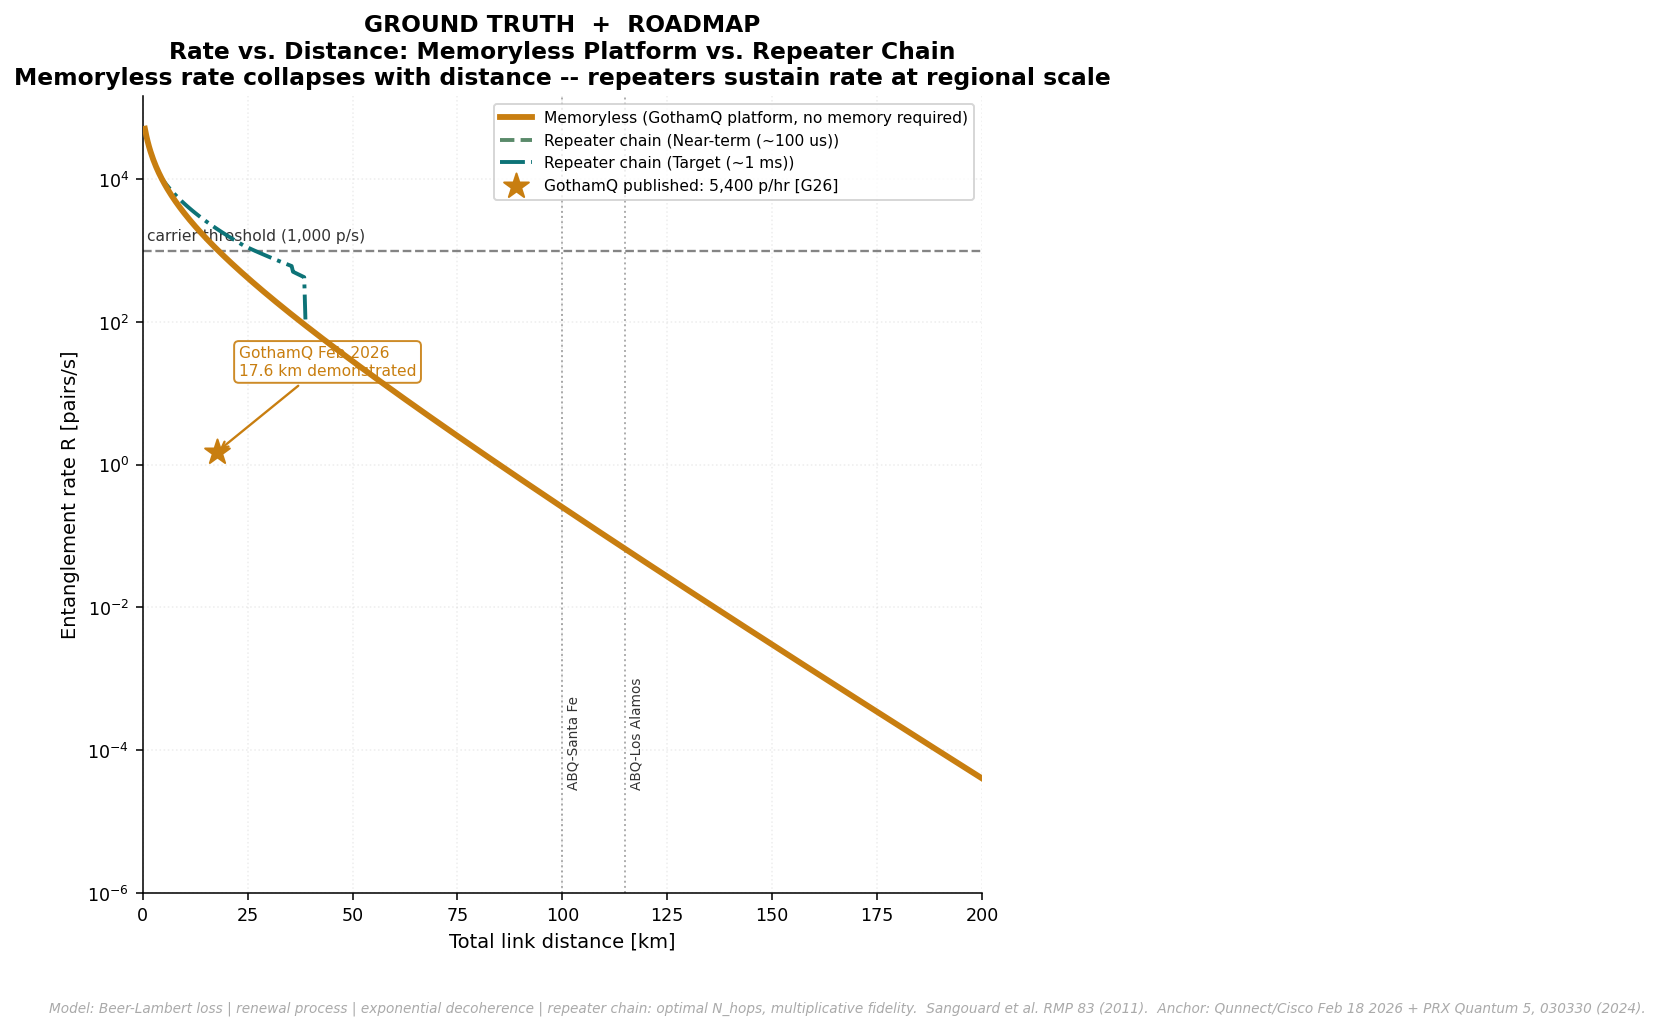

Saved: fig1_rate_memoryless_vs_repeater.png


In [7]:
# -- Fig 1 [CORE]: Rate vs. distance -- memoryless vs. repeater chains -------
# THE linchpin figure. Shows why repeaters are necessary and what memory buys.
# Memoryless: rate collapses exponentially -- GothamQ platform, proven today.
# Repeater chains: rate sustained at longer distances, memory is the enabler.

fig, ax = plt.subplots(figsize=SQ)

p = GOTHAMQ

# Memoryless curve
mem_data = df_chain[df_chain["label"] == "Memoryless"]
ax.semilogy(km2disp(mem_data["L_km"]), mem_data["R"],
            color=C_GOTHAM, lw=3, ls="-",
            label="Memoryless (GothamQ platform, no memory required)",
            zorder=5)

# Repeater chain curves -- one per T_mem tier
for (label, T_us, color, ls) in MEM_TIERS:
    rep_data = df_chain[df_chain["label"] == label].copy()
    # Solid where viable, dashed where not
    viable   = rep_data[rep_data["viable"] == True]
    nonviable = rep_data[rep_data["viable"] == False]
    if len(viable):
        ax.semilogy(km2disp(viable["L_km"]), viable["R"],
                    color=color, lw=2, ls=ls, label=f"Repeater chain ({label})",
                    zorder=4)
    if len(nonviable):
        ax.semilogy(km2disp(nonviable["L_km"]), nonviable["R"],
                    color=color, lw=1, ls=":", alpha=0.4, zorder=3)

# GothamQ published point
R_pub = GOTHAMQ["R_published_pairs_hr"] / 3600.0
ax.scatter([km2disp(GOTHAMQ["L_total_km"])], [R_pub],
           color=C_GOTHAM, s=180, zorder=10, marker="*",
           label=f"GothamQ published: {GOTHAMQ['R_published_pairs_hr']:,} p/hr [G26]")
ax.annotate(f"GothamQ Feb 2026\n{GOTHAMQ['L_total_km']} km demonstrated",
            xy=(km2disp(GOTHAMQ["L_total_km"]), R_pub),
            xytext=(km2disp(GOTHAMQ["L_total_km"])*1.3, R_pub*12),
            arrowprops=dict(arrowstyle="->", color=C_GOTHAM, lw=1.2),
            fontsize=8, color=C_GOTHAM,
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white",
                      edgecolor=C_GOTHAM, alpha=0.9))

# Carrier threshold
ax.axhline(1e3, ls="--", color=C_THRESH, lw=1.2, alpha=0.6)
ax.text(km2disp(1), 1.4e3, "carrier threshold (1,000 p/s)", fontsize=8, color=C_THRESH)

# Regional reference lines
for label_r, km_r in [("ABQ-Santa Fe", 100), ("ABQ-Los Alamos", 115)]:
    ax.axvline(km2disp(km_r), ls=":", color=C_THRESH, lw=1, alpha=0.4)
    ax.text(km2disp(km_r)+km2disp(1), ax.get_ylim()[0]*2,
            label_r, fontsize=7, color=C_THRESH, rotation=90, va="bottom")

ax.set_xlabel(f"Total link distance [{UL}]")
ax.set_ylabel("Entanglement rate R [pairs/s]")
ax.set_xlim(0, km2disp(200))
ax.set_ylim(bottom=1e-6)
ax.set_title(f"{ACT1}  +  {ACT2}\n"
             "Rate vs. Distance: Memoryless Platform vs. Repeater Chain\n"
             "Memoryless rate collapses with distance -- repeaters sustain rate at regional scale",
             fontweight="bold")
ax.legend(loc="upper right", fontsize=8)
fig.text(0.01, -0.04, CAVEAT, fontsize=7, color=C_CAVEAT, style="italic")
plt.tight_layout()
plt.savefig("fig1_rate_memoryless_vs_repeater.png", bbox_inches="tight")
plt.show()
print("Saved: fig1_rate_memoryless_vs_repeater.png")


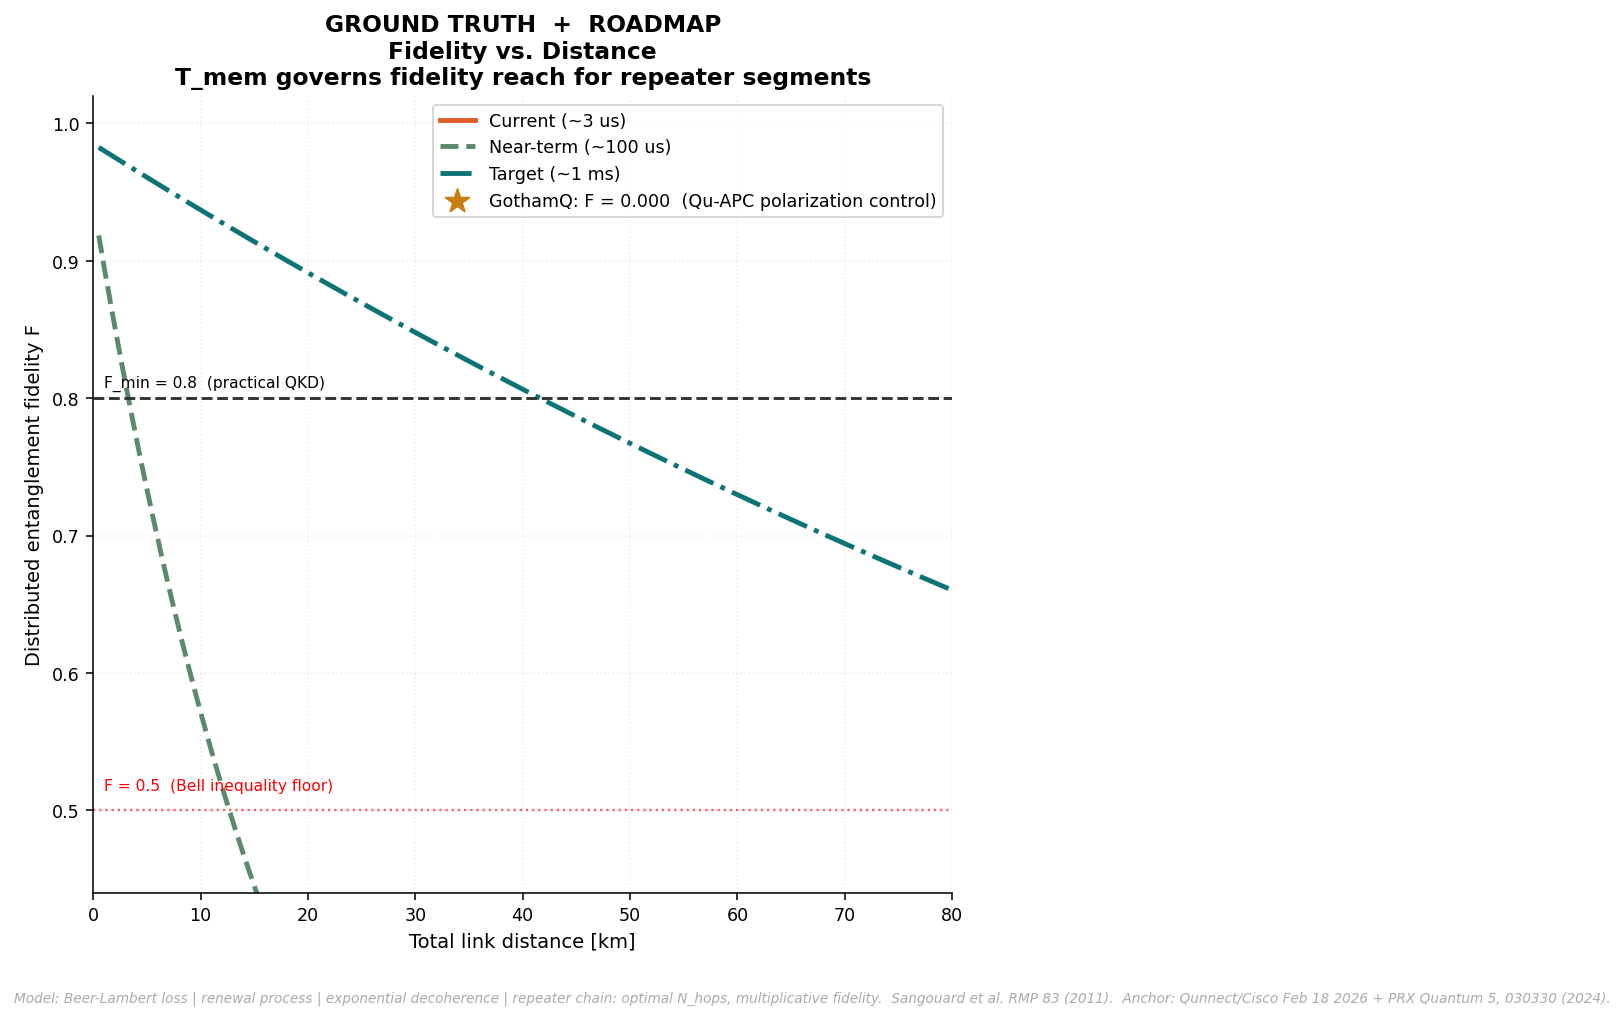

In [8]:
# -- Fig 2 [ACT 1+2]: Fidelity vs. distance ----------------------------------
fig, ax = plt.subplots(figsize=SQ)

for (label, T_us, color, ls) in MEM_TIERS:
    sub = df_sweep_L[df_sweep_L["label"] == label]
    ax.plot(km2disp(sub["L_km"]), sub["F"],
            color=color, lw=2.5, ls=ls, label=label)

ax.axhline(PARAMS["F_min"]["value"], ls="--", color=C_THRESH, lw=1.5)
ax.text(km2disp(1), PARAMS["F_min"]["value"]+0.008,
        f"F_min = {PARAMS['F_min']['value']}  (practical QKD)", fontsize=8)
ax.axhline(0.50, ls=":", color="red", lw=1.2, alpha=0.6)
ax.text(km2disp(1), 0.515, "F = 0.5  (Bell inequality floor)", fontsize=8, color="red")

F_g = fidelity(GOTHAMQ["L_total_km"], GOTHAMQ["tau_orch_us"],
               GOTHAMQ["T_mem_us"], GOTHAMQ["F_source"], GOTHAMQ["p_dc"])
ax.scatter([km2disp(GOTHAMQ["L_total_km"])], [F_g],
           color=C_GOTHAM, s=160, zorder=9, marker="*",
           label=f"GothamQ: F = {F_g:.3f}  (Qu-APC polarization control)")
ax.annotate("Fidelity held by\nQu-APC -- not T_mem",
            xy=(km2disp(GOTHAMQ["L_total_km"]), F_g),
            xytext=(km2disp(38), 0.72),
            arrowprops=dict(arrowstyle="->", color=C_GOTHAM, lw=1.2),
            fontsize=8, color=C_GOTHAM,
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white",
                      edgecolor=C_GOTHAM, alpha=0.85))

ax.set_xlabel(f"Total link distance [{UL}]")
ax.set_ylabel("Distributed entanglement fidelity F")
ax.set_ylim(0.44, 1.02)
ax.set_xlim(0, km2disp(80))
ax.set_title(f"{ACT1}  +  {ACT2}\nFidelity vs. Distance\n"
             "T_mem governs fidelity reach for repeater segments",
             fontweight="bold")
ax.legend(loc="upper right")
fig.text(0.01, -0.03, CAVEAT, fontsize=7, color=C_CAVEAT, style="italic")
plt.tight_layout()
plt.savefig("fig2_fidelity_vs_distance.png", bbox_inches="tight")
plt.show()


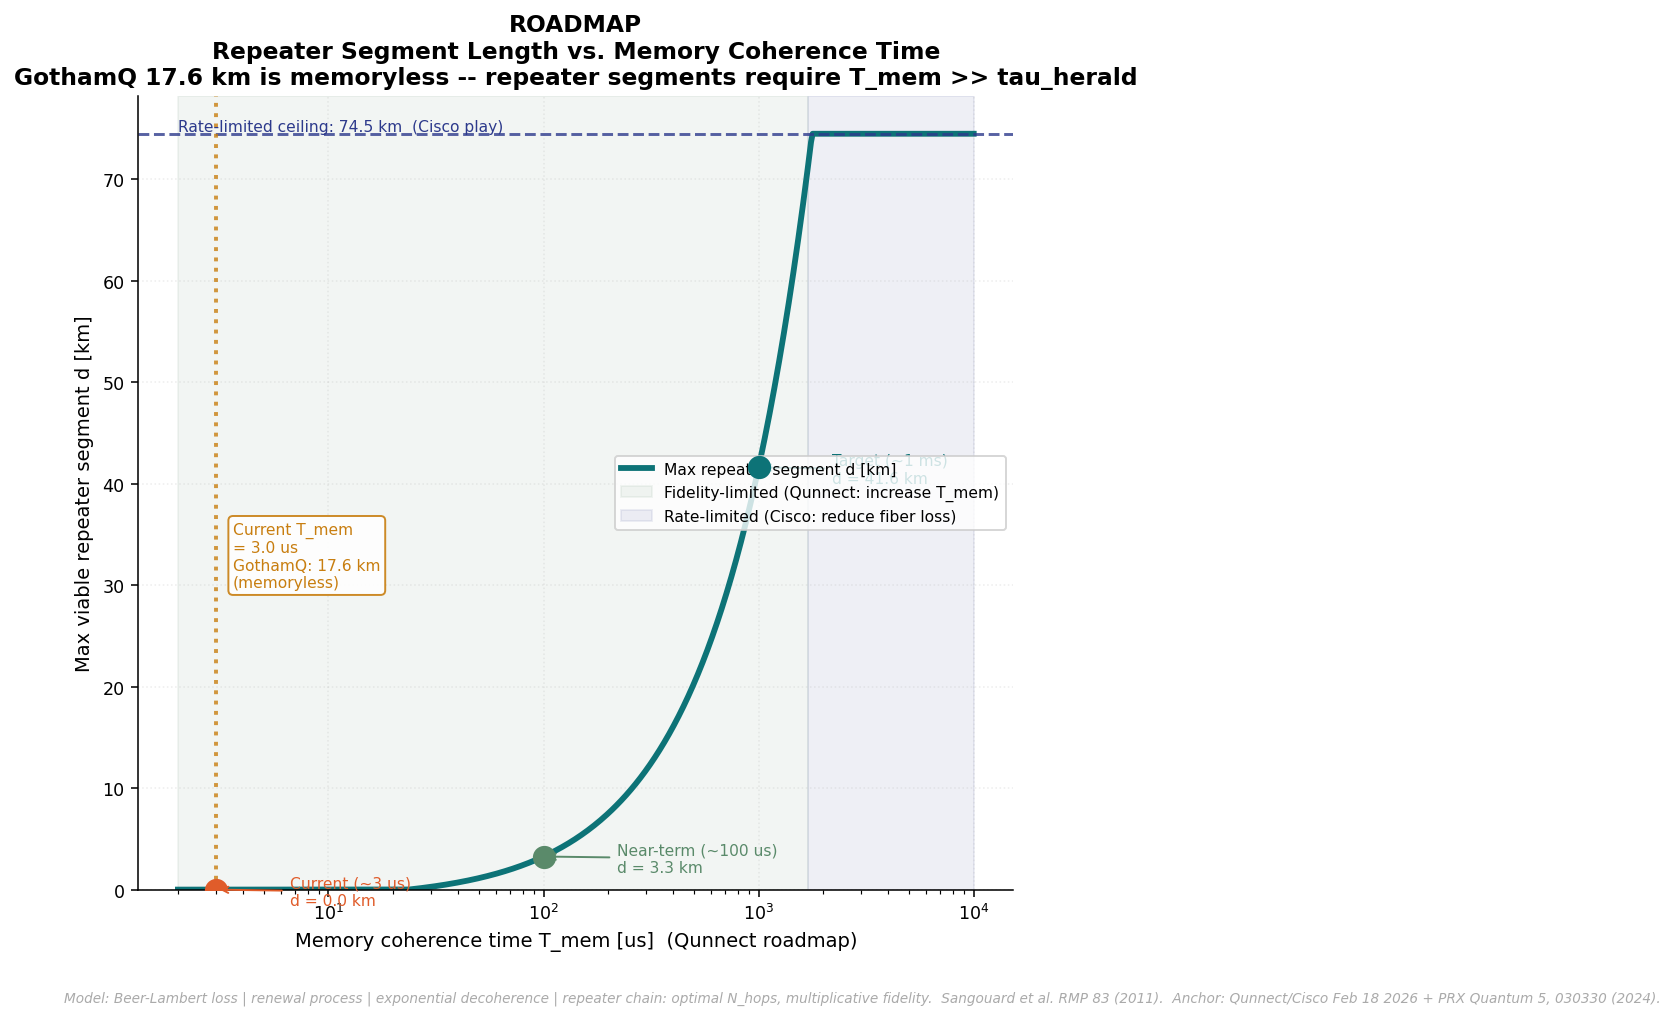

In [9]:
# -- Fig 3 [ACT 2]: d vs. T_mem -- roadmap figure ---------------------------
T_mem_range = np.logspace(0.3, 4, 500)
d_vals_roadmap = np.array([
    invert_d(PARAMS["P_success_target"]["value"],
             PARAMS["F_min"]["value"],
             GOTHAMQ["alpha_dBkm"], GOTHAMQ["eta_det"], GOTHAMQ["p_s"],
             T_us, GOTHAMQ["F_source"], GOTHAMQ["p_dc"],
             GOTHAMQ["tau_orch_us"])["d"]
    for T_us in T_mem_range
])

fig, ax = plt.subplots(figsize=SQ)
ax.semilogx(T_mem_range, km2disp(d_vals_roadmap),
            color=C_VIABLE, lw=3, label=f"Max repeater segment d [{UL}]")

d_rate_val = invert_d(PARAMS["P_success_target"]["value"],
                      PARAMS["F_min"]["value"],
                      GOTHAMQ["alpha_dBkm"], GOTHAMQ["eta_det"], GOTHAMQ["p_s"],
                      1e6, GOTHAMQ["F_source"], GOTHAMQ["p_dc"],
                      GOTHAMQ["tau_orch_us"])["d_rate"]
ax.axhline(km2disp(d_rate_val), ls="--", color=C_CISCO, lw=1.5, alpha=0.8)
ax.text(2, km2disp(d_rate_val)+km2disp(0.3),
        f"Rate-limited ceiling: {km2disp(d_rate_val):.1f} {UL}  (Cisco play)",
        fontsize=8, color=C_CISCO)

T_transition = T_mem_range[np.argmin(np.abs(d_vals_roadmap - d_rate_val*0.95))]
ax.axvspan(T_mem_range[0], T_transition, alpha=0.08, color=C_QUNNECT,
           label="Fidelity-limited (Qunnect: increase T_mem)")
ax.axvspan(T_transition, T_mem_range[-1], alpha=0.08, color=C_CISCO,
           label="Rate-limited (Cisco: reduce fiber loss)")

for (label, T_us, color, ls) in MEM_TIERS:
    d_tier = invert_d(PARAMS["P_success_target"]["value"],
                      PARAMS["F_min"]["value"],
                      GOTHAMQ["alpha_dBkm"], GOTHAMQ["eta_det"], GOTHAMQ["p_s"],
                      T_us, GOTHAMQ["F_source"], GOTHAMQ["p_dc"],
                      GOTHAMQ["tau_orch_us"])["d"]
    ax.scatter([T_us], [km2disp(d_tier)], color=color, s=120, zorder=8)
    ax.annotate(f"{label}\nd = {km2disp(d_tier):.1f} {UL}",
                xy=(T_us, km2disp(d_tier)),
                xytext=(T_us*2.2, km2disp(d_tier)-km2disp(1.5)),
                arrowprops=dict(arrowstyle="->", color=color, lw=1),
                fontsize=8, color=color)

ax.axvline(GOTHAMQ["T_mem_us"], ls=":", color=C_GOTHAM, lw=2, alpha=0.8)
ax.text(GOTHAMQ["T_mem_us"]*1.2, km2disp(d_rate_val)*0.4,
        f"Current T_mem\n= {GOTHAMQ['T_mem_us']} us\nGothamQ: {GOTHAMQ['L_total_km']} km\n(memoryless)",
        fontsize=8, color=C_GOTHAM,
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white",
                  edgecolor=C_GOTHAM, alpha=0.9))

ax.set_xlabel("Memory coherence time T_mem [us]  (Qunnect roadmap)")
ax.set_ylabel(f"Max viable repeater segment d [{UL}]")
ax.set_ylim(bottom=0)
ax.set_title(f"{ACT2}\nRepeater Segment Length vs. Memory Coherence Time\n"
             "GothamQ 17.6 km is memoryless -- repeater segments require T_mem >> tau_herald",
             fontweight="bold")
ax.legend(loc="center right", fontsize=8)
fig.text(0.01, -0.03, CAVEAT, fontsize=7, color=C_CAVEAT, style="italic")
plt.tight_layout()
plt.savefig("fig3_d_vs_Tmem.png", bbox_inches="tight")
plt.show()


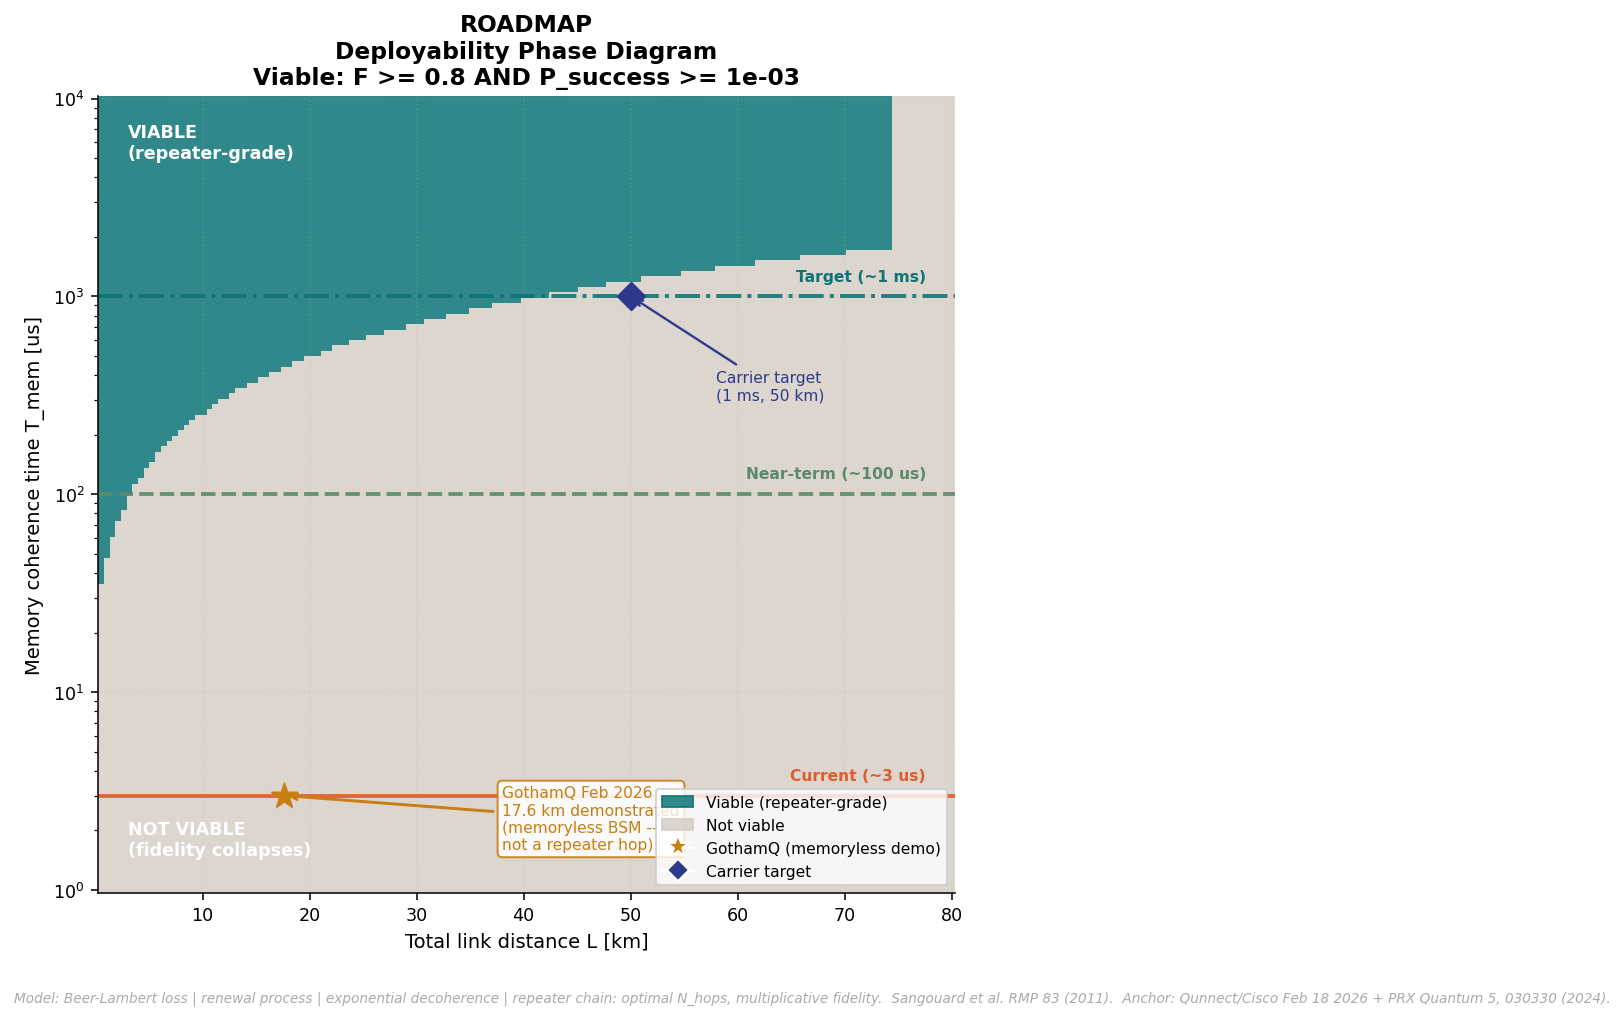

In [10]:
# -- Fig 4 [ACT 2]: Phase diagram -- T_mem x distance -----------------------
# Single square panel: viability map.
# GothamQ clearly in NOT VIABLE region for repeater -- memoryless label.

fig, ax = plt.subplots(figsize=SQ)

T_g = df_phase["T_grid"]
L_g = df_phase["L_grid"]

cmap_bin = mcolors.LinearSegmentedColormap.from_list(
    "vmap", [C_NOVIABLE, C_VIABLE], N=2)
ax.pcolormesh(L_g, T_g, df_phase["VIABLE"].astype(float),
              cmap=cmap_bin, shading="auto", vmin=0, vmax=1, alpha=0.85)
ax.set_yscale("log")

# Roadmap tier lines
for (label, T_us, color, ls) in MEM_TIERS:
    ax.axhline(T_us, ls=ls, color=color, lw=2, alpha=0.9)
    ax.text(L_g[-1]*0.97, T_us*1.2, label,
            ha="right", fontsize=8, color=color, fontweight="bold")

# GothamQ -- memoryless, clearly in NOT VIABLE repeater region
ax.scatter([GOTHAMQ["L_total_km"]], [GOTHAMQ["T_mem_us"]],
           color=C_GOTHAM, s=180, zorder=10, marker="*")
ax.annotate("GothamQ Feb 2026\n17.6 km demonstrated\n(memoryless BSM -- \nnot a repeater hop)",
            xy=(GOTHAMQ["L_total_km"], GOTHAMQ["T_mem_us"]),
            xytext=(38, 1.6),
            arrowprops=dict(arrowstyle="->", color=C_GOTHAM, lw=1.5),
            fontsize=8, color=C_GOTHAM,
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white",
                      edgecolor=C_GOTHAM, alpha=0.9))

# Carrier target
ax.scatter([CARRIER["L_total_km"]], [CARRIER["T_mem_us"]],
           color=C_CARRIER, s=100, zorder=10, marker="D")
ax.annotate("Carrier target\n(1 ms, 50 km)",
            xy=(CARRIER["L_total_km"], CARRIER["T_mem_us"]),
            xytext=(58, 300),
            arrowprops=dict(arrowstyle="->", color=C_CARRIER, lw=1.2),
            fontsize=8, color=C_CARRIER)

# Region labels
ax.text(3, 1.5, "NOT VIABLE\n(fidelity collapses)", fontsize=9,
        color="white", fontweight="bold")
ax.text(3, 5000, "VIABLE\n(repeater-grade)", fontsize=9,
        color="white", fontweight="bold")

legend_handles = [
    mpatches.Patch(color=C_VIABLE,   alpha=0.85, label="Viable (repeater-grade)"),
    mpatches.Patch(color=C_NOVIABLE, alpha=0.85, label="Not viable"),
    Line2D([0],[0], marker="*", color="w", markerfacecolor=C_GOTHAM,
           markersize=12, label="GothamQ (memoryless demo)"),
    Line2D([0],[0], marker="D", color="w", markerfacecolor=C_CARRIER,
           markersize=8,  label="Carrier target"),
]
ax.legend(handles=legend_handles, loc="lower right", fontsize=8)
ax.set_xlabel("Total link distance L [km]")
ax.set_ylabel("Memory coherence time T_mem [us]")
ax.set_title(f"{ACT2}\nDeployability Phase Diagram\n"
             f"Viable: F >= {df_phase['F_min']} AND P_success >= {df_phase['P_target']:.0e}",
             fontweight="bold")
fig.text(0.01, -0.03, CAVEAT, fontsize=7, color=C_CAVEAT, style="italic")
plt.tight_layout()
plt.savefig("fig4_phase_diagram.png", bbox_inches="tight")
plt.show()


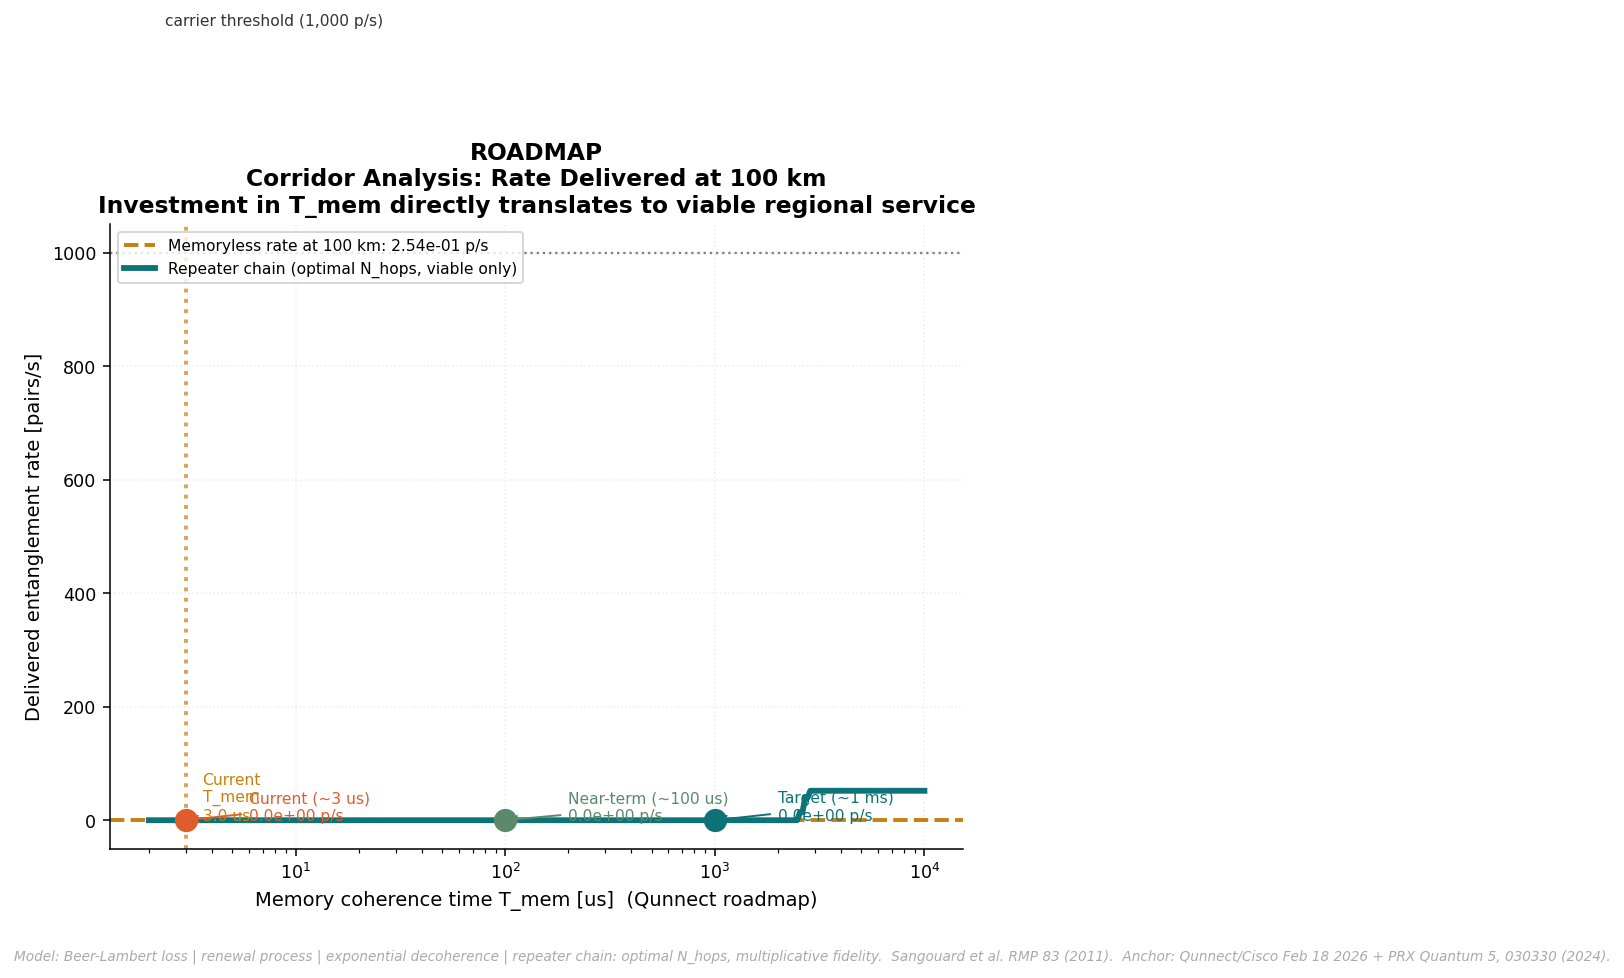

Saved: fig5_corridor_analysis.png  (corridor = 100 km)


In [11]:
# -- Fig 5 [ACT 2]: Corridor analysis -- rate at target distance -------------
# For a user-specified corridor length, show rate delivered
# by memoryless link vs. repeater chain as T_mem improves.
# This is the legislature/regional figure.

CORRIDOR_KM = 100.0   # change this -- ABQ to Santa Fe

T_range = np.logspace(0.3, 4, 300)

R_memless_corr = memoryless_rate(
    CORRIDOR_KM, GOTHAMQ["alpha_dBkm"], GOTHAMQ["eta_det"],
    GOTHAMQ["p_s"], GOTHAMQ["f_rep_MHz"], GOTHAMQ["tau_orch_us"])

R_repeater = []
F_repeater = []
N_optimal  = []
for T_us in T_range:
    best_R = 0; best_N = 1; best_F = 0
    for N in range(1, 21):
        res = repeater_chain_rate(
            CORRIDOR_KM, N, GOTHAMQ["alpha_dBkm"], GOTHAMQ["eta_det"],
            GOTHAMQ["p_s"], GOTHAMQ["f_rep_MHz"], GOTHAMQ["tau_orch_us"],
            T_us, GOTHAMQ["F_source"], GOTHAMQ["p_dc"])
        if res["fidelity"] >= PARAMS["F_min"]["value"] and res["rate"] > best_R:
            best_R = res["rate"]; best_N = N; best_F = res["fidelity"]
    R_repeater.append(best_R); F_repeater.append(best_F); N_optimal.append(best_N)

R_repeater = np.array(R_repeater)
F_repeater = np.array(F_repeater)

fig, ax = plt.subplots(figsize=SQ)

# Memoryless baseline
ax.axhline(R_memless_corr, ls="--", color=C_GOTHAM, lw=2,
           label=f"Memoryless rate at {km2disp(CORRIDOR_KM):.0f} {UL}: "
                 f"{R_memless_corr:.2e} p/s")

# Repeater rate vs T_mem
ax.semilogx(T_range, R_repeater, color=C_VIABLE, lw=3,
            label="Repeater chain (optimal N_hops, viable only)")

# Mark T_mem tiers
for (label, T_us, color, ls) in MEM_TIERS:
    idx = np.argmin(np.abs(T_range - T_us))
    R_t = R_repeater[idx]
    ax.scatter([T_us], [R_t], color=color, s=120, zorder=8)
    ax.annotate(f"{label}\n{R_t:.1e} p/s",
                xy=(T_us, R_t), xytext=(T_us*2, R_t*3),
                arrowprops=dict(arrowstyle="->", color=color, lw=1),
                fontsize=8, color=color)

# Carrier threshold
ax.axhline(1e3, ls=":", color=C_THRESH, lw=1.2, alpha=0.6)
ax.text(T_range[0]*1.2, 1.4e3, "carrier threshold (1,000 p/s)",
        fontsize=8, color=C_THRESH)

# Current T_mem
ax.axvline(GOTHAMQ["T_mem_us"], ls=":", color=C_GOTHAM, lw=2, alpha=0.7)
ax.text(GOTHAMQ["T_mem_us"]*1.2, ax.get_ylim()[0] if ax.get_ylim()[0] > 0 else 1e-4,
        f"Current\nT_mem\n{GOTHAMQ['T_mem_us']} us", fontsize=8, color=C_GOTHAM)

ax.set_xlabel("Memory coherence time T_mem [us]  (Qunnect roadmap)")
ax.set_ylabel("Delivered entanglement rate [pairs/s]")
ax.set_title(f"{ACT2}\nCorridor Analysis: Rate Delivered at {km2disp(CORRIDOR_KM):.0f} {UL}\n"
             "Investment in T_mem directly translates to viable regional service",
             fontweight="bold")
ax.legend(loc="upper left", fontsize=8)
fig.text(0.01, -0.03, CAVEAT, fontsize=7, color=C_CAVEAT, style="italic")
plt.tight_layout()
plt.savefig("fig5_corridor_analysis.png", bbox_inches="tight")
plt.show()
print(f"Saved: fig5_corridor_analysis.png  (corridor = {km2disp(CORRIDOR_KM):.0f} {UL})")


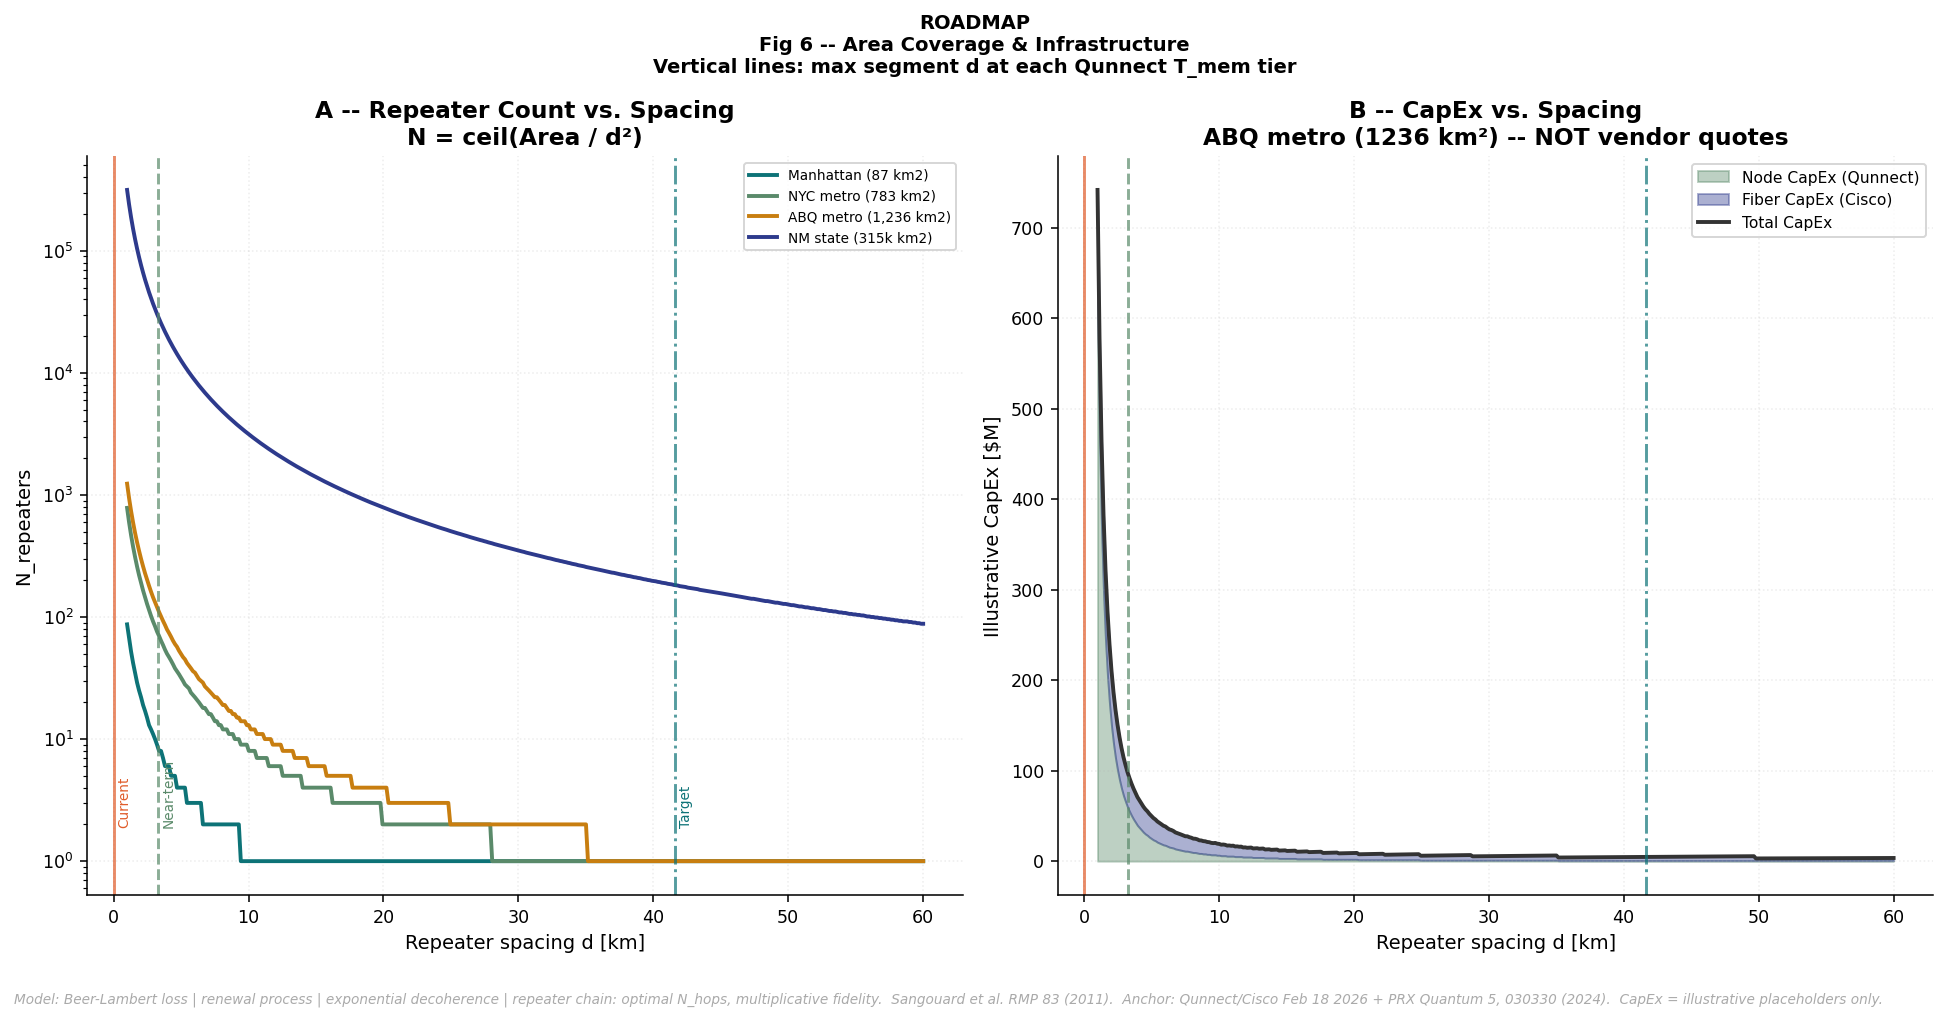

In [12]:
# -- Fig 6 [ACT 2]: Area coverage -- N repeaters + CapEx --------------------
fig, axes = plt.subplots(1, 2, figsize=SQ2)

d_range = np.linspace(1, 60, 400)
AREA_KM2 = 1236.0   # ABQ metro default

C_n = PARAMS["C_node_kUSD"]["value"]
C_f = PARAMS["C_fiber_kUSD_per_km"]["value"]

# Panel A: N_repeaters vs. d for several areas
areas = [
    ("Manhattan (87 km2)",    87,     C_VIABLE),
    ("NYC metro (783 km2)",   783,    C_QUNNECT),
    ("ABQ metro (1,236 km2)", 1236,   C_GOTHAM),
    ("NM state (315k km2)",   315000, C_CISCO),
]
for (name, A, color) in areas:
    N = np.array([int(np.ceil(A / d**2)) for d in d_range])
    axes[0].semilogy(km2disp(d_range), N, lw=2, color=color, label=name)

# Mark T_mem tier d values
for (label, T_us, color, ls) in MEM_TIERS:
    inv = invert_d(PARAMS["P_success_target"]["value"], PARAMS["F_min"]["value"],
                   GOTHAMQ["alpha_dBkm"], GOTHAMQ["eta_det"], GOTHAMQ["p_s"],
                   T_us, GOTHAMQ["F_source"], GOTHAMQ["p_dc"], GOTHAMQ["tau_orch_us"])
    axes[0].axvline(km2disp(inv["d"]), ls=ls, color=color, lw=1.5, alpha=0.7)
    axes[0].text(km2disp(inv["d"])+km2disp(0.3), 2,
                 label.split("(")[0].strip(), fontsize=7, color=color, rotation=90)

axes[0].set_xlabel(f"Repeater spacing d [{UL}]")
axes[0].set_ylabel("N_repeaters")
axes[0].set_title("A -- Repeater Count vs. Spacing\nN = ceil(Area / d\u00b2)",
                  fontweight="bold")
axes[0].legend(fontsize=7)

# Panel B: CapEx vs. d (ABQ metro reference)
N_r = np.array([int(np.ceil(AREA_KM2 / d**2)) for d in d_range])
N_l = np.array([int(np.ceil(2*AREA_KM2 / d**2)) for d in d_range])
cap_n = N_r * C_n / 1e3
cap_f = N_l * d_range * C_f / 1e3
cap_t = cap_n + cap_f

axes[1].fill_between(km2disp(d_range), 0, cap_n, alpha=0.4,
                     color=C_QUNNECT, label="Node CapEx (Qunnect)")
axes[1].fill_between(km2disp(d_range), cap_n, cap_t, alpha=0.4,
                     color=C_CISCO, label="Fiber CapEx (Cisco)")
axes[1].plot(km2disp(d_range), cap_t, color=C_THRESH, lw=2, label="Total CapEx")

for (label, T_us, color, ls) in MEM_TIERS:
    inv = invert_d(PARAMS["P_success_target"]["value"], PARAMS["F_min"]["value"],
                   GOTHAMQ["alpha_dBkm"], GOTHAMQ["eta_det"], GOTHAMQ["p_s"],
                   T_us, GOTHAMQ["F_source"], GOTHAMQ["p_dc"], GOTHAMQ["tau_orch_us"])
    axes[1].axvline(km2disp(inv["d"]), ls=ls, color=color, lw=1.5, alpha=0.7)

axes[1].set_xlabel(f"Repeater spacing d [{UL}]")
axes[1].set_ylabel("Illustrative CapEx [$M]")
axes[1].set_title(f"B -- CapEx vs. Spacing\nABQ metro ({AREA_KM2:.0f} km\u00b2) -- NOT vendor quotes",
                  fontweight="bold")
axes[1].legend(fontsize=8)

fig.suptitle(f"{ACT2}\nFig 6 -- Area Coverage & Infrastructure\n"
             "Vertical lines: max segment d at each Qunnect T_mem tier",
             fontsize=10, fontweight="bold")
fig.text(0.01, -0.03, CAVEAT + "  CapEx = illustrative placeholders only.",
         fontsize=7, color=C_CAVEAT, style="italic")
plt.tight_layout()
plt.savefig("fig6_area_coverage.png", bbox_inches="tight")
plt.show()


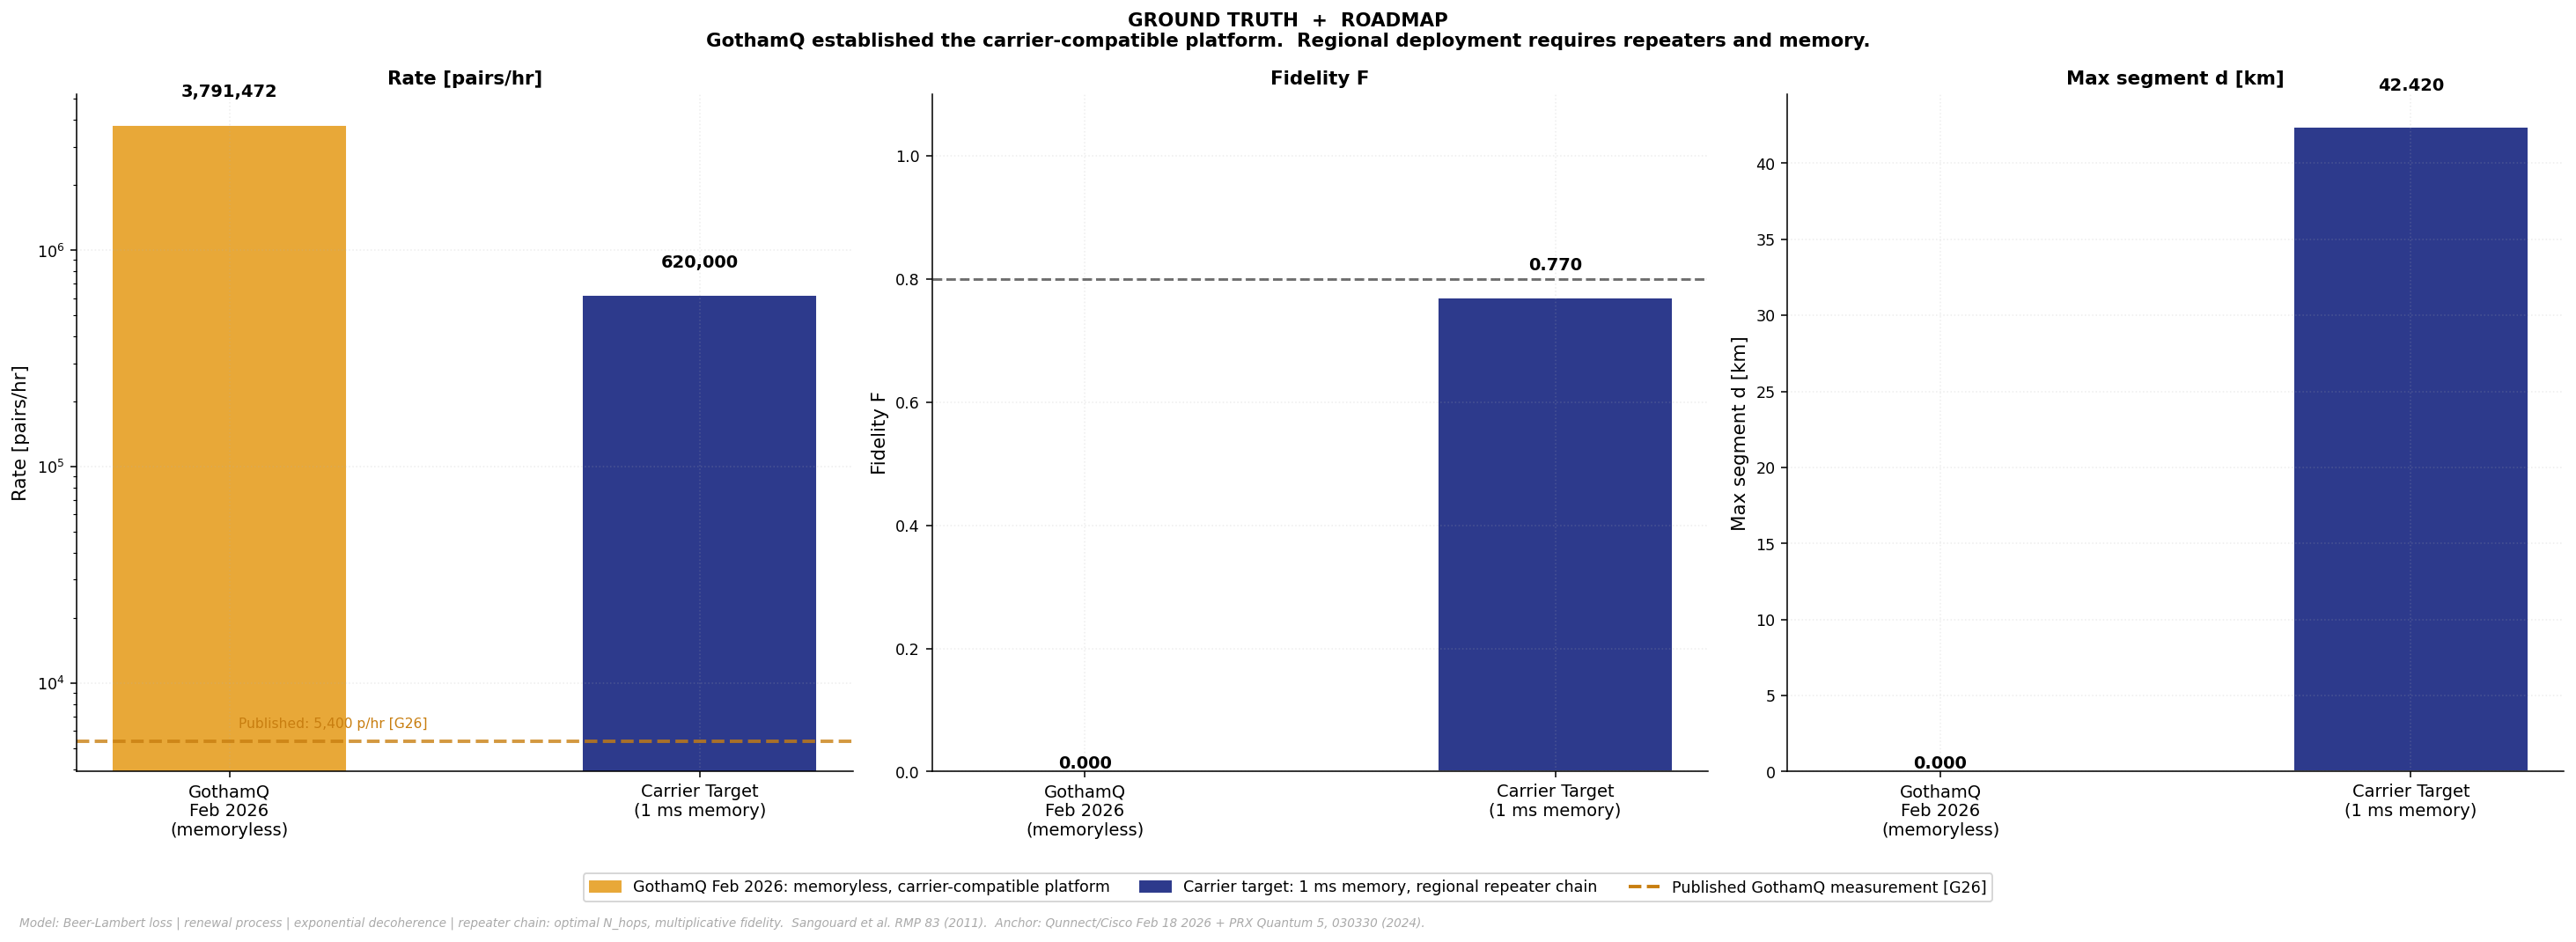

In [13]:
# -- Fig 7 [ACT 1+2]: Scenario comparison ------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(21, 7))

metrics = [
    ("R_pairs_hr", "Rate [pairs/hr]",        True),
    ("F",          "Fidelity F",              False),
    ("d_max_km",   f"Max segment d [{UL}]",   False),
]
colors = [GOTHAMQ["color"], CARRIER["color"]]
labels = ["GothamQ\nFeb 2026\n(memoryless)", "Carrier Target\n(1 ms memory)"]

for ax, (col, ylabel, use_log) in zip(axes, metrics):
    vals = df_scenarios[col].values
    if col == "d_max_km":
        vals = km2disp(vals)
    bars = ax.bar(labels, vals, color=colors, width=0.5, edgecolor="white")
    for bar, val in zip(bars, vals):
        fmt = f"{val:,.0f}" if col == "R_pairs_hr" else f"{val:.3f}"
        ax.text(bar.get_x() + bar.get_width()/2,
                bar.get_height() * (1.05 if not use_log else 1.3),
                fmt, ha="center", va="bottom", fontsize=10, fontweight="bold")
    if use_log:
        ax.set_yscale("log")
    ax.set_ylabel(ylabel, fontsize=11)
    ax.set_title(ylabel, fontweight="bold", fontsize=11)
    ax.tick_params(axis="x", labelsize=10)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    if col == "R_pairs_hr":
        ax.axhline(GOTHAMQ["R_published_pairs_hr"], ls="--",
                   color=C_GOTHAM, lw=2, alpha=0.8)
        ax.text(0.02, GOTHAMQ["R_published_pairs_hr"]*1.15,
                f"Published: {GOTHAMQ['R_published_pairs_hr']:,} p/hr [G26]",
                fontsize=8, color=C_GOTHAM)
    if col == "F":
        ax.axhline(PARAMS["F_min"]["value"], ls="--",
                   color=C_THRESH, lw=1.5, alpha=0.7)
        ax.set_ylim(0, 1.1)

legend_el = [
    mpatches.Patch(color=GOTHAMQ["color"],
                   label="GothamQ Feb 2026: memoryless, carrier-compatible platform"),
    mpatches.Patch(color=CARRIER["color"],
                   label="Carrier target: 1 ms memory, regional repeater chain"),
    Line2D([0],[0], ls="--", color=C_GOTHAM, lw=2,
           label="Published GothamQ measurement [G26]"),
]
fig.legend(handles=legend_el, loc="lower center", ncol=3,
           fontsize=9, bbox_to_anchor=(0.5, -0.06))

fig.suptitle(f"{ACT1}  +  {ACT2}\n"
             "GothamQ established the carrier-compatible platform.  "
             "Regional deployment requires repeaters and memory.",
             fontsize=11, fontweight="bold")
fig.text(0.01, -0.08, CAVEAT, fontsize=7, color=C_CAVEAT, style="italic")
plt.tight_layout()
plt.savefig("fig7_scenario_comparison.png", bbox_inches="tight")
plt.show()
